In [37]:
import torch
import torch.nn.functional as F
import torch.nn as nn
from torch_geometric.nn import GENConv, GATv2Conv, SSGConv
import numpy as np
from torch_geometric.data import Data
from torch.utils.data import DataLoader
import torch_geometric.utils

from tqdm import tqdm

from sklearn.model_selection import KFold, train_test_split
import pandas as pd
from MatrixVectorizer import MatrixVectorizer


In [38]:
# set global variables
N_SUBJECTS = 167

N_LR_NODES = 160

N_HR_NODES = 268

DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'

N_LR_NODES_F = int(N_LR_NODES * (N_LR_NODES-1) / 2)
N_HR_NODES_F = int(N_HR_NODES * (N_HR_NODES-1) / 2)

In [39]:
from data_preparation import load_data_tensor

lr_train, lr_test, hr_train = load_data_tensor("dgl-icl")

lr_X_dim1 = torch.load('model_autoencoder/final_embeddings/encode_lr.pt')
lr_X_dim3 = torch.load('model_autoencoder/final_embeddings/encode_lr_3.pt')
hr_X_dim1 = torch.load('model_autoencoder/final_embeddings/encode_hr.pt')
hr_X_dim3 = torch.load('model_autoencoder/final_embeddings/encode_hr_3.pt')
lr_X_dim1_test = torch.load('model_autoencoder/final_embeddings/encode_lr_test.pt')
lr_X_dim3_test = torch.load('model_autoencoder/final_embeddings/encode_lr_test_3.pt')

# Model Layers

In [40]:
def generate_steps(num_steps, low=N_LR_NODES, high=N_HR_NODES):
    step_size = (high - low) / (num_steps - 1)
    steps_list = [round(low + step_size * i) for i in range(num_steps)]
    return steps_list

In [41]:
class StackedGCN(nn.Module):
    def __init__(self, n_nodes, channel_ls, dropout):
        super().__init__()
        self.n_nodes = n_nodes
        self.gcn_layers, self.batch_norm_layers = self._init_layers(channel_ls)

        # self.gcn_layers, _ = self._init_layers(channel_ls)
        self.dropout = dropout
        
    
    def forward(self, X, A):
        for i in range(len(self.gcn_layers)):
            gcn = self.gcn_layers[i]
            batch_norm = self.batch_norm_layers[i]
            graph_batch = self._create_batch(X, A)
            
            X = F.sigmoid(gcn(graph_batch.x, graph_batch.edge_index, graph_batch.edge_attr).reshape(*X.shape[:2], -1))
            torch.cuda.empty_cache()
            X = F.dropout(batch_norm(X), self.dropout, training=self.training)
            # X = F.dropout(X, self.dropout, training=self.training)
            torch.cuda.empty_cache()

        return X

    def _init_layers(self, channel_ls):
        layers_ls = []
        batch_norm_ls = []
        for i in range(len(channel_ls) - 1):
            layer = GATv2Conv(channel_ls[i], channel_ls[i], heads=2, edge_dim=1)
            layers_ls.append(layer)
            batch_norm_ls.append(torch_geometric.nn.norm.BatchNorm(self.n_nodes, affine=False))
        return nn.ModuleList(layers_ls), nn.ModuleList(batch_norm_ls)

    def _create_batch(self, X, A):
        data_list = []
        for x, adj in zip(X, A):
            edge_index = adj.nonzero().t()
            edge_weights = adj[edge_index[0], edge_index[1]]
            edge_index, edge_weights = torch_geometric.utils.add_self_loops(edge_index, edge_weights) # add self connections
            data = Data(x=x, edge_index=edge_index, edge_attr=edge_weights.view(-1, 1))
            data_list.append(data)
        return torch_geometric.data.Batch().from_data_list(data_list)

In [42]:
class AdjacencyStep(nn.Module):
    def __init__(self, old_dim, new_dim):
        super().__init__()

        self.A_dim_changer = nn.Parameter(torch.randn((new_dim, old_dim), device=DEVICE))
        # self.A_dim_changer1 = nn.Parameter(torch.randn((new_dim, 1), device=DEVICE))   
        # self.A_dim_changer2 = nn.Parameter(torch.randn((1, old_dim), device=DEVICE))
        self.A_dim_bias = nn.Parameter(torch.randn((new_dim, 1), device=DEVICE))

        self.Z_dim_changer = nn.Parameter(torch.randn((channels_ls[-1], new_dim), device=DEVICE))
        # self.Z_dim_changer1 = nn.Parameter(torch.randn((channels_ls[-1], 1), device=DEVICE))   
        # self.Z_dim_changer2 = nn.Parameter(torch.randn((1, new_dim), device=DEVICE))
        self.Z_dim_bias = nn.Parameter(torch.randn((new_dim, 1), device=DEVICE))

        self.forget_gate = nn.Parameter(torch.randn(new_dim, device=DEVICE))
        self.input_gate = nn.Parameter(torch.randn(new_dim, device=DEVICE))
        # self.output_gate = nn.Parameter(torch.randn(new_dim, device=DEVICE))

        self.layernorm_forget_A = torch_geometric.nn.norm.LayerNorm((new_dim, new_dim))
        self.layernorm_input_Z = torch_geometric.nn.norm.LayerNorm((new_dim, new_dim))
        self.batchnorm_A = torch_geometric.nn.norm.BatchNorm(new_dim)


    def forward(self, Z, A, dim_changer):
        Z_dim_changer = self.Z_dim_changer
        A_dim_changer = self.A_dim_changer

        f = F.sigmoid(self.forget_gate)
        i = F.sigmoid(self.input_gate)

        # input gate from node features
        input_Z = F.elu(dim_changer @ Z @ Z_dim_changer + self.Z_dim_bias)
        # input_Z = i[:, None] * self.layernorm_input_Z(input_Z)
        input_Z = i[:, None] * input_Z
        torch.cuda.empty_cache()


        # forget gate from previous adjacency
        forget_A = F.elu(A_dim_changer @ A @ A_dim_changer.T + self.A_dim_bias)
        # forget_A = f[:, None] * self.layernorm_forget_A(forget_A)
        forget_A = f[:, None] * forget_A
        torch.cuda.empty_cache()

        # get new adjacency matrix
        new_A = forget_A + input_Z
        new_A = self.batchnorm_A(new_A)
        new_A = (new_A + torch.transpose(new_A, -1, -2)) / 2
        # new_A = F.tanh(F.relu(new_A))
        new_A = F.hardtanh(F.hardtanh(new_A, min_val=0), min_val=0)

        return new_A


In [43]:
class FeatureStep(nn.Module):
    def __init__(self, old_dim, new_dim, channels_ls, dt=1., alpha=0.8, gamma=0.8, dropout=0.3):
        super().__init__()
        self.dt = dt
        self.alpha = alpha
        self.gamma = gamma
        self.gnn = StackedGCN(old_dim, channels_ls, dropout).to(DEVICE)
        self.dropout = dropout

        
        # self.dim_changer1 = nn.Parameter(torch.randn((new_dim, 1), device=DEVICE))
        # self.dim_changer2 = nn.Parameter(torch.randn((1, old_dim), device=DEVICE))
        self.dim_changer = nn.Parameter(torch.randn((new_dim, old_dim), device=DEVICE))

        self.Z_dim_lower = nn.Conv1d(channels_ls[-1], channels_ls[0], kernel_size=1)

        self.batchnorm_X = torch_geometric.nn.norm.BatchNorm(new_dim)
        self.batchnorm_Y = torch_geometric.nn.norm.BatchNorm(new_dim)



    def forward(self, X, Y, A):
        # solve ODEs using simple IMEX scheme
        # dim_changer = self.dim_changer1 @ self.dim_changer2 
        dim_changer = self.dim_changer
    
        # update node features with gcn
        Z = self.gnn(X, A)

        # update feature embeiddings
        W = torch.transpose(self.Z_dim_lower(torch.transpose(Z, -1, -2)), -1, -2)
        Y_temp = Y
        Y = dim_changer @ (Y + self.dt * (W - self.alpha * Y - self.gamma * X))
        X = dim_changer @ (X + self.dt * Y_temp) 

        X = self.batchnorm_X(X)
        Y = self.batchnorm_Y(Y)   
        torch.cuda.empty_cache()


        Y = F.dropout(Y, self.dropout, training=self.training)
        X = F.dropout(X, self.dropout, training=self.training)

        return X, Y, Z, dim_changer

    

In [44]:
class AdjacencyDimChanger(nn.Module):

    def __init__(self, dim_steps, channels_ls, embedding_dims_ls=None):
        super().__init__()
        self.n_steps = len(dim_steps)-1

        self.feature_steps = nn.ModuleList([FeatureStep(dim_steps[i], dim_steps[i+1], channels_ls) for i in range(self.n_steps)])
        self.adjacency_steps = nn.ModuleList([AdjacencyStep(dim_steps[i], dim_steps[i+1]) for i in range(self.n_steps)])
        
    def forward(self, X, Y, A):
        
        adj_ls = [A]
        x, y, adj = X, Y, A
    
        for i in range(self.n_steps):
            x, y, z, dim_changer = self.feature_steps[i](x, y, adj)
            adj = self.adjacency_steps[i](z, adj, dim_changer)
            adj_ls.append(adj)
        
        return adj_ls
        

In [45]:
def freeze_model(model):
    for param in model.parameters():
        param.requires_grad = False

def unfreeze_model(model):
    for param in model.parameters():
        param.requires_grad = True

In [46]:
# to calculate end loss
def end_adj_loss_calc(adj, opp_adj):
    mae_loss_fn = torch.nn.L1Loss()
    n = len(adj)
    upper_tri_idx = torch.triu_indices(n, n, offset=1)
    upper_tri_adj = adj[upper_tri_idx.unbind()]
    upper_tri_opp_adj = opp_adj[upper_tri_idx.unbind()]
    mae_loss = mae_loss_fn(upper_tri_adj, upper_tri_opp_adj)
    return mae_loss

# to calculate adj at each step
def inter_adj_loss_calc(adj_ls, opp_adj_ls):
    total_loss = torch.Tensor([0]).to(DEVICE)
    mse_loss_fn = nn.MSELoss()

    n = len(opp_adj_ls)
    weights = torch.Tensor([1/n for i in range(n)])
    
    # calculate the loss for the remaining intermediate adjacent matrices
    for i, (adj, opp_adj) in enumerate(zip(adj_ls[:], opp_adj_ls[::-1])):
        total_loss = total_loss + weights[i] * mse_loss_fn(adj, opp_adj)

    return total_loss

def l1_regularization_loss(models, l1_lambda):
    l1_reg_loss = torch.Tensor([0]).to(DEVICE)
    for model in models:
        all_params = torch.cat([p.view(-1) for p in model.parameters()])
        l1_reg_loss = l1_reg_loss + l1_lambda * torch.norm(all_params, 1)
    return l1_reg_loss

# Training

In [47]:
# trainloader = DataLoader(list(zip(lr_X_dim1, lr_X_dim3, lr_train, hr_X_dim1, hr_X_dim3, hr_train)), shuffle=True, batch_size=16)

train_idx, val_idx = train_test_split(list(range(len(lr_train))), test_size=0.2, shuffle=True, random_state=99)
trainloader = DataLoader(list(zip(lr_X_dim1[train_idx], lr_X_dim3[train_idx], lr_train[train_idx], hr_X_dim1[train_idx], hr_X_dim3[train_idx], hr_train[train_idx])), shuffle=True, batch_size=64)
valloader = DataLoader(list(zip(lr_X_dim1[val_idx], lr_X_dim3[val_idx], lr_train[val_idx], hr_X_dim1[val_idx], hr_X_dim3[val_idx], hr_train[val_idx])), shuffle=True, batch_size=64)


testloader = DataLoader(list(zip(lr_X_dim1_test, lr_X_dim3_test, lr_test)), shuffle=False, batch_size=32)


In [48]:

dim_steps = generate_steps(num_steps=6)
channels_ls = [32, 64]
embedding_dims_ls_up = [160,64,32]
embedding_dims_ls_down = [268,64,32]

up_changer = AdjacencyDimChanger(dim_steps, channels_ls, embedding_dims_ls_up).to(DEVICE)
down_changer = AdjacencyDimChanger(dim_steps[::-1], channels_ls, embedding_dims_ls_down).to(DEVICE)

up_optimizer = torch.optim.AdamW(up_changer.parameters(), lr=0.007)
down_optimizer = torch.optim.AdamW(down_changer.parameters(), lr=0.007)

reconstruction_optimizer = torch.optim.AdamW(list(up_changer.parameters()) + list(down_changer.parameters()), lr=0.003)

final_optimizer = torch.optim.AdamW(up_changer.parameters(), lr=0.0005)


sum(p.numel() for model in [up_changer, down_changer] for p in model.parameters())


3028884

In [49]:
def inter_adj_train(epochs, up_changer, down_changer, trainloader, up_optimizer, down_optimizer, valloader=None, completed_epochs=0, loss_log=None):

    if loss_log is None:
        loss_log = {'up': [], 'down': [], 'val_up':[], 'val_down': [], 'final_mae': [], 'val_final_mae': []}


    # gamma = 1 
    l1_lambda = 0.000001 # for L1 regularization
    for epoch in tqdm(range(epochs), desc='Intermediate Adj. Training', position=0, leave=True):

        up_losses = []
        final_mae_ls = []
        down_losses = []

        up_changer.train()
        down_changer.train()   
            

        for X_lr, Y_lr, adj_lr, X_hr, Y_hr, adj_hr in trainloader:

            freeze_model(up_changer)
            unfreeze_model(down_changer)
        
            down_optimizer.zero_grad()

            # forward pass
            up_adj_ls = up_changer(X_lr.to(DEVICE), Y_lr.to(DEVICE), adj_lr.to(DEVICE))
            torch.cuda.empty_cache()
            down_adj_ls = down_changer(X_hr.to(DEVICE), Y_hr.to(DEVICE), adj_hr.to(DEVICE))
            torch.cuda.empty_cache()

            # compute losses
            down_loss = inter_adj_loss_calc(down_adj_ls[1:], up_adj_ls[:-1]) + l1_regularization_loss([down_changer], l1_lambda)

            # backpropogate the down changer
            down_loss.backward()
            down_optimizer.step()
            down_losses.append(down_loss.detach().item())
            del down_loss
            torch.cuda.empty_cache()

            unfreeze_model(up_changer)
            freeze_model(down_changer)
            
            up_optimizer.zero_grad()

            # forward pass
            up_adj_ls = up_changer(X_lr.to(DEVICE), Y_lr.to(DEVICE), adj_lr.to(DEVICE))
            torch.cuda.empty_cache()
            down_adj_ls = down_changer(X_hr.to(DEVICE), Y_hr.to(DEVICE), adj_hr.to(DEVICE))
            torch.cuda.empty_cache()

            # compute losses
            up_loss = inter_adj_loss_calc(up_adj_ls[1:], down_adj_ls[:-1]) + l1_regularization_loss([up_changer], l1_lambda)
            
            
            final_mae_ls.append(end_adj_loss_calc(up_adj_ls[-1], adj_hr.to(DEVICE)).detach().item())

            # backpropogate the up changer
            up_loss.backward()
            up_optimizer.step()
            up_losses.append(up_loss.detach().item())
            del up_loss
            torch.cuda.empty_cache()



        # perform validation
        if valloader is not None:

            up_changer.eval()
            down_changer.eval()
    
            val_down_loss_ls = []
            val_up_loss_ls = []
            val_final_mae_ls = []
        
            for X_lr, Y_lr, adj_lr, X_hr, Y_hr, adj_hr in valloader:
        
                freeze_model(up_changer)
                freeze_model(down_changer)
        
                # perform forward pass
                up_adj_ls = up_changer(X_lr.to(DEVICE), Y_lr.to(DEVICE), adj_lr.to(DEVICE))
                down_adj_ls = down_changer(X_hr.to(DEVICE), Y_hr.to(DEVICE), adj_hr.to(DEVICE))
                torch.cuda.empty_cache()
        

                # record loss
                down_loss = inter_adj_loss_calc(down_adj_ls[1:], up_adj_ls[:-1]) + l1_regularization_loss([down_changer], l1_lambda)
                up_loss = inter_adj_loss_calc(up_adj_ls[1:], down_adj_ls[:-1]) + l1_regularization_loss([up_changer], l1_lambda)
        
                val_up_loss_ls.append(up_loss.detach().item())
                val_down_loss_ls.append(down_loss.detach().item())
                val_final_mae_ls.append(end_adj_loss_calc(up_adj_ls[-1], adj_hr.to(DEVICE)).detach().item())
            
            epoch_val_up_loss = np.mean(val_up_loss_ls)
            epoch_val_down_loss = np.mean(val_down_loss_ls)
            epoch_val_final_mae = np.mean(val_final_mae_ls)

            loss_log['val_up'].append(epoch_val_up_loss)
            loss_log['val_down'].append(epoch_val_down_loss)
            loss_log['val_final_mae'].append(epoch_val_final_mae)
            

        epoch_up_loss = np.mean(up_losses)
        epoch_down_loss = np.mean(down_losses)
        epoch_final_mae = np.mean(final_mae_ls)
        
        loss_log['up'].append(epoch_up_loss)
        loss_log['down'].append(epoch_down_loss)
        loss_log['final_mae'].append(epoch_final_mae)
        
        if valloader is not None:

            tqdm.write(f'Ep{epoch}: DOWN={epoch_down_loss}, DOWN VAL={epoch_val_down_loss}, UP={epoch_up_loss}, UP VAL={epoch_val_up_loss}, FINAL MAE={epoch_final_mae}, VAL FINAL MAE={epoch_val_final_mae}')

        else: 

            tqdm.write(f'Ep{epoch}: DOWN={epoch_down_loss}, UP={epoch_up_loss}, FINAL MAE={epoch_final_mae}')

    return up_changer, down_changer, loss_log


In [50]:
def reconstruction_train(epochs, up_changer, down_changer, trainloader, reconstruction_optimizer, valloader=None, completed_epochs=0, loss_log=None):

    if loss_log is None:
        loss_log = {'up_down': [], 'down_up': [], 'val_up_down':[], 'val_down_up': [], 'reconstr': [], 'final_mae': [], 'val_final_mae':[]}

    unfreeze_model(up_changer)
    unfreeze_model(down_changer)

    # freeze the paths between the adjacency matrices
    #for adj_step in up_changer.adjacency_steps:
    #    freeze_model(adj_step)

    #for adj_step in down_changer.adjacency_steps:
    #    freeze_model(adj_step)

    # gamma = 1 
    l1_lambda = 0.00000 # for L1 regularization
    for epoch in tqdm(range(epochs), desc='Reconstruction Loss Training'):

        final_mae_ls = []
        down_up_reconstr_ls = []
        up_down_reconstr_ls = []
        reconstruction_losses = []

        up_changer.train()
        down_changer.train()   
            

        for X_lr, Y_lr, adj_lr, X_hr, Y_hr, adj_hr in trainloader:

            reconstruction_optimizer.zero_grad()

            # calculate the down-up reconstruction loss
            down_adj_end = down_changer(X_hr.to(DEVICE), Y_hr.to(DEVICE), adj_hr.to(DEVICE))[-1]
            torch.cuda.empty_cache()
            hr_adj_reconst = up_changer(X_lr.to(DEVICE), Y_lr.to(DEVICE), down_adj_end)[-1]
            torch.cuda.empty_cache()

            down_up_reconst_loss = end_adj_loss_calc(hr_adj_reconst, adj_hr.to(DEVICE))
            down_up_reconstr_ls.append(down_up_reconst_loss.detach().item())

            # calculate the up-down reconstruction loss
            up_adj_end = up_changer(X_lr.to(DEVICE), Y_lr.to(DEVICE), adj_lr.to(DEVICE))[-1]
            torch.cuda.empty_cache()
            lr_adj_reconst = down_changer(X_hr.to(DEVICE), Y_hr.to(DEVICE), up_adj_end)[-1]
            torch.cuda.empty_cache()

            up_down_reconst_loss = end_adj_loss_calc(lr_adj_reconst, adj_lr.to(DEVICE))
            up_down_reconstr_ls.append(up_down_reconst_loss.detach().item())

            final_mae_ls.append(end_adj_loss_calc(up_adj_end, adj_hr.to(DEVICE)).detach().item())

            reconstruction_loss = down_up_reconst_loss + up_down_reconst_loss + l1_regularization_loss([up_changer, down_changer], l1_lambda)

            # back propogate
            reconstruction_loss.backward()
            reconstruction_optimizer.step()
            torch.cuda.empty_cache()

            reconstruction_losses.append(reconstruction_loss.detach().item())

            del reconstruction_loss
            del up_down_reconst_loss
            del down_up_reconst_loss
            torch.cuda.empty_cache()

        # perform validation
        if valloader is not None:

            up_changer.eval()
            down_changer.eval()
    
            val_final_mae_ls = []
            val_up_down_reconstr_ls = []
            val_down_up_reconstr_ls = []

            for X_lr, Y_lr, adj_lr, X_hr, Y_hr, adj_hr in valloader:
        
                # calculate the down-up reconstruction loss
                down_adj_end = down_changer(X_hr.to(DEVICE), Y_hr.to(DEVICE), adj_hr.to(DEVICE))[-1]
                torch.cuda.empty_cache()
                hr_adj_reconst = up_changer(X_lr.to(DEVICE), Y_lr.to(DEVICE), down_adj_end)[-1]
                torch.cuda.empty_cache()

                # calculate the up-down reconstruction loss
                up_adj_end = up_changer(X_lr.to(DEVICE), Y_lr.to(DEVICE), adj_lr.to(DEVICE))[-1]
                torch.cuda.empty_cache()
                lr_adj_reconst = down_changer(X_hr.to(DEVICE), Y_hr.to(DEVICE), up_adj_end)[-1]
                torch.cuda.empty_cache()

                # record loss
                val_down_up_reconstr_ls.append(end_adj_loss_calc(hr_adj_reconst, adj_hr.to(DEVICE)).detach().item())
                val_up_down_reconstr_ls.append(end_adj_loss_calc(lr_adj_reconst, adj_lr.to(DEVICE)).detach().item())
                val_final_mae_ls.append(end_adj_loss_calc(up_adj_end, adj_hr.to(DEVICE)).detach().item())

            
            epoch_val_down_up_reconstr = np.mean(val_down_up_reconstr_ls)
            epoch_val_up_down_reconstr = np.mean(val_up_down_reconstr_ls)
            epoch_val_final_mae = np.mean(val_final_mae_ls)

            loss_log['val_down_up'].append(epoch_val_down_up_reconstr)
            loss_log['val_up_down'].append(epoch_val_up_down_reconstr)
            loss_log['val_final_mae'].append(epoch_val_final_mae)


        epoch_reconstr_loss = np.mean(reconstruction_losses)
        epoch_down_up_reconstr = np.mean(down_up_reconstr_ls)
        epoch_up_down_reconstr = np.mean(up_down_reconstr_ls)
        epoch_final_mae = np.mean(final_mae_ls)

        loss_log['reconstr'].append(epoch_reconstr_loss)
        loss_log['down_up'].append(epoch_down_up_reconstr)
        loss_log['up_down'].append(epoch_up_down_reconstr)
        loss_log['final_mae'].append(epoch_final_mae)
        
        if valloader is not None:

            print(f'Ep{epoch}: RECON.={epoch_reconstr_loss}, DOWN-UP={epoch_down_up_reconstr}, VAL DOWN-UP={epoch_val_down_up_reconstr}, UP-DOWN={epoch_up_down_reconstr}, VAL UP-DOWN={epoch_val_up_down_reconstr}, END MAE={epoch_final_mae}, VAL END MAE={epoch_val_final_mae}')

        else: 

            print(f'Ep{epoch}: RECON.={epoch_reconstr_loss}, DOWN-UP={epoch_down_up_reconstr}, UP-DOWN={epoch_up_down_reconstr}, END MAE={epoch_final_mae}')


    return up_changer, down_changer, loss_log


In [51]:
def reconstruction_train(epochs, up_changer, down_changer, trainloader, reconstruction_optimizer, valloader=None, completed_epochs=0, loss_log=None):

    if loss_log is None:
        loss_log = {'up_down': [], 'down_up': [], 'val_up_down':[], 'val_down_up': [], 'reconstr': [], 'final_mae': [], 'val_final_mae':[]}

    unfreeze_model(up_changer)
    unfreeze_model(down_changer)

    # freeze the paths between the adjacency matrices
    for adj_step in up_changer.adjacency_steps:
        freeze_model(adj_step)

    for adj_step in down_changer.adjacency_steps:
        freeze_model(adj_step)

    # gamma = 1 
    l1_lambda = 0 # for L1 regularization
    for epoch in tqdm(range(epochs), desc='Reconstruction Loss Training'):

        final_mae_ls = []
        down_up_reconstr_ls = []
        up_down_reconstr_ls = []
        reconstruction_losses = []

        up_changer.train()
        down_changer.train()   
            

        for X_lr, Y_lr, adj_lr, X_hr, Y_hr, adj_hr in trainloader:

            reconstruction_optimizer.zero_grad()

            # calculate the down-up reconstruction loss
            down_adj_end = down_changer(X_hr.to(DEVICE), Y_hr.to(DEVICE), adj_hr.to(DEVICE))[-1]
            torch.cuda.empty_cache()
            hr_adj_reconst = up_changer(X_lr.to(DEVICE), Y_lr.to(DEVICE), down_adj_end)[-1]
            torch.cuda.empty_cache()

            down_up_reconst_loss = end_adj_loss_calc(hr_adj_reconst, adj_hr.to(DEVICE))
            down_up_reconstr_ls.append(down_up_reconst_loss.detach().item())

            # calculate the up-down reconstruction loss
            up_adj_end = up_changer(X_lr.to(DEVICE), Y_lr.to(DEVICE), adj_lr.to(DEVICE))[-1]
            torch.cuda.empty_cache()

            final_mae_ls.append(end_adj_loss_calc(up_adj_end, adj_hr.to(DEVICE)).detach().item())

            reconstruction_loss = down_up_reconst_loss + l1_regularization_loss([up_changer, down_changer], l1_lambda)

            # back propogate
            reconstruction_loss.backward()
            reconstruction_optimizer.step()
            torch.cuda.empty_cache()

            reconstruction_losses.append(reconstruction_loss.detach().item())

            del reconstruction_loss
            torch.cuda.empty_cache()

        # perform validation
        if valloader is not None:

            up_changer.eval()
            down_changer.eval()
    
            val_final_mae_ls = []
            val_up_down_reconstr_ls = []
            val_down_up_reconstr_ls = []

            for X_lr, Y_lr, adj_lr, X_hr, Y_hr, adj_hr in valloader:
        
                # calculate the down-up reconstruction loss
                down_adj_end = down_changer(X_hr.to(DEVICE), Y_hr.to(DEVICE), adj_hr.to(DEVICE))[-1]
                torch.cuda.empty_cache()
                hr_adj_reconst = up_changer(X_lr.to(DEVICE), Y_lr.to(DEVICE), down_adj_end)[-1]
                torch.cuda.empty_cache()

                # calculate the up-down reconstruction loss
                up_adj_end = up_changer(X_lr.to(DEVICE), Y_lr.to(DEVICE), adj_lr.to(DEVICE))[-1]
                torch.cuda.empty_cache()

                # record loss
                val_down_up_reconstr_ls.append(end_adj_loss_calc(hr_adj_reconst, adj_hr.to(DEVICE)).detach().item())
                val_final_mae_ls.append(end_adj_loss_calc(up_adj_end, adj_hr.to(DEVICE)).detach().item())

            
            epoch_val_down_up_reconstr = np.mean(val_down_up_reconstr_ls)
            epoch_val_final_mae = np.mean(val_final_mae_ls)

            loss_log['val_final_mae'].append(epoch_val_final_mae)


        epoch_reconstr_loss = np.mean(reconstruction_losses)
        epoch_final_mae = np.mean(final_mae_ls)

        loss_log['reconstr'].append(epoch_reconstr_loss)
        loss_log['final_mae'].append(epoch_final_mae)
        
        if valloader is not None:

            print(f'Ep{epoch}: RECON.={epoch_reconstr_loss}, END MAE={epoch_final_mae}, VAL END MAE={epoch_val_final_mae}')

        else: 

            print(f'Ep{epoch}: RECON.={epoch_reconstr_loss}, END MAE={epoch_final_mae}')


    return up_changer, down_changer, loss_log

In [52]:
def final_train(epochs, up_changer, down_changer, trainloader, final_optimizer, valloader=None, completed_epochs=0, loss_log=None):
 
    if loss_log is None:
        loss_log = {'reconstr': [], 'final_mae': [], 'val_final_mae':[]}
 
    unfreeze_model(up_changer)
 
 
    # freeze the paths between the adjacency matrices
    #for adj_step in up_changer.adjacency_steps:
    #    freeze_model(adj_step)
 
    # freeze the down changer
    freeze_model(down_changer)
 
 
    # gamma = 1
    l1_lambda = 0.000001 # for L1 regularization
    for epoch in tqdm(range(epochs), desc='Final Loss Training', position=0, leave=True):
 
        final_mae_ls = []
        reconstr_ls = []
 
        up_changer.train()
        down_changer.eval()  
            
 
        for X_lr, Y_lr, adj_lr, X_hr, Y_hr, adj_hr in trainloader:
 
            final_optimizer.zero_grad()
 
            # calculate the reconstruction loss to add noise
            down_adj_end = down_changer(X_hr.to(DEVICE), Y_hr.to(DEVICE), adj_hr.to(DEVICE))[-1]
            torch.cuda.empty_cache()
            hr_adj_reconstr = up_changer(X_lr.to(DEVICE), Y_lr.to(DEVICE), down_adj_end)[-1]
            torch.cuda.empty_cache()
            reconstr_loss = end_adj_loss_calc(hr_adj_reconstr, adj_hr.to(DEVICE)) + l1_regularization_loss([up_changer], l1_lambda)
 
            # back propogate
            reconstr_loss.backward()
            final_optimizer.step()
            torch.cuda.empty_cache()
 
            reconstr_ls.append(reconstr_loss.detach().item())
            del reconstr_loss
 
            final_optimizer.zero_grad()
 
            # calculate the final mae loss
            up_adj_end = up_changer(X_lr.to(DEVICE), Y_lr.to(DEVICE), adj_lr.to(DEVICE))[-1]
            torch.cuda.empty_cache()
            final_mae = end_adj_loss_calc(up_adj_end, adj_hr.to(DEVICE))
            final_loss = final_mae + l1_regularization_loss([up_changer], l1_lambda)
 
            # back propogate
            final_loss.backward()
            final_optimizer.step()
            torch.cuda.empty_cache()
 
            final_mae_ls.append(final_mae.detach().item())
            del final_mae
 
 
        # perform validation
        if valloader is not None:
    
            val_final_mae_ls = []
            up_changer.eval()
            down_changer.eval()
        
            for X_lr, Y_lr, adj_lr, X_hr, Y_hr, adj_hr in valloader:
        
                # calculate the down-up reconstruction loss
                up_adj_end = up_changer(X_lr.to(DEVICE), Y_lr.to(DEVICE), adj_lr.to(DEVICE))[-1]
                torch.cuda.empty_cache()
                end_adj_loss_calc(up_adj_end, adj_hr.to(DEVICE))
 
                # record loss
                val_final_mae_ls.append(end_adj_loss_calc(up_adj_end, adj_hr.to(DEVICE)).detach().item())
 
            
            epoch_val_final_mae = np.mean(val_final_mae_ls)
 
            loss_log['val_final_mae'].append(epoch_val_final_mae)
            
 
        epoch_final_mae = np.mean(final_mae_ls)
        epoch_reconstr = np.mean(reconstr_ls)
 
        loss_log['final_mae'].append(epoch_final_mae)
        loss_log['reconstr'].append(epoch_reconstr)
        
        if valloader is not None:
 
            print(f'Ep{epoch}: RECONSTR.={epoch_reconstr}, FINAL MAE={epoch_final_mae}, VAL FINAL MAE={epoch_val_final_mae}')
 
        else:
 
            print(f'Ep{epoch}: RECONSTR.={epoch_reconstr}, FINAL MAE={epoch_final_mae}')
 
 
    return up_changer, down_changer, loss_log

In [53]:
up_changer, down_changer, inter_loss_log = inter_adj_train(100, up_changer, down_changer, trainloader, up_optimizer, down_optimizer, valloader=valloader)

Intermediate Adj. Training:   1%|          | 1/100 [00:03<05:06,  3.09s/it]

Ep0: DOWN=1.0939020315806072, DOWN VAL=1.0888274908065796, UP=1.1901671091715496, UP VAL=1.1880264282226562, FINAL MAE=0.3487322926521301, VAL FINAL MAE=0.3528710603713989


Intermediate Adj. Training:   2%|▏         | 2/100 [00:05<04:48,  2.94s/it]

Ep1: DOWN=1.0572580496470134, DOWN VAL=0.8876181840896606, UP=1.1518845558166504, UP VAL=0.985791802406311, FINAL MAE=0.3350802759329478, VAL FINAL MAE=0.262967973947525


Intermediate Adj. Training:   3%|▎         | 3/100 [00:08<04:36,  2.85s/it]

Ep2: DOWN=1.018529971440633, DOWN VAL=0.8485350012779236, UP=1.1121164560317993, UP VAL=0.9432616233825684, FINAL MAE=0.3180643618106842, VAL FINAL MAE=0.2677742540836334


Intermediate Adj. Training:   4%|▍         | 4/100 [00:11<04:26,  2.78s/it]

Ep3: DOWN=0.9819865425427755, DOWN VAL=0.8313186764717102, UP=1.0728973150253296, UP VAL=0.9227181673049927, FINAL MAE=0.3094916145006816, VAL FINAL MAE=0.25766807794570923


Intermediate Adj. Training:   5%|▌         | 5/100 [00:13<04:16,  2.70s/it]

Ep4: DOWN=0.9547149737675985, DOWN VAL=0.8196063041687012, UP=1.0412627458572388, UP VAL=0.9077969193458557, FINAL MAE=0.2933051784833272, VAL FINAL MAE=0.2614039182662964


Intermediate Adj. Training:   6%|▌         | 6/100 [00:16<04:07,  2.63s/it]

Ep5: DOWN=0.9161874254544576, DOWN VAL=0.8085488080978394, UP=1.0002715388933818, UP VAL=0.8935914635658264, FINAL MAE=0.2946641842524211, VAL FINAL MAE=0.2722027897834778


Intermediate Adj. Training:   7%|▋         | 7/100 [00:18<04:00,  2.58s/it]

Ep6: DOWN=0.8980501890182495, DOWN VAL=0.8101364374160767, UP=0.9788559675216675, UP VAL=0.8918962478637695, FINAL MAE=0.2862449884414673, VAL FINAL MAE=0.2646041512489319


Intermediate Adj. Training:   8%|▊         | 8/100 [00:21<03:51,  2.52s/it]

Ep7: DOWN=0.8739681045214335, DOWN VAL=0.8101973533630371, UP=0.9517301122347513, UP VAL=0.8894320726394653, FINAL MAE=0.286372313896815, VAL FINAL MAE=0.25963348150253296


Intermediate Adj. Training:   9%|▉         | 9/100 [00:23<03:43,  2.45s/it]

Ep8: DOWN=0.8450457056363424, DOWN VAL=0.8014857172966003, UP=0.9204253951708475, UP VAL=0.8763610124588013, FINAL MAE=0.28865639368693036, VAL FINAL MAE=0.25938645005226135


Intermediate Adj. Training:  10%|█         | 10/100 [00:25<03:34,  2.38s/it]

Ep9: DOWN=0.8191846410433451, DOWN VAL=0.7917982339859009, UP=0.8937326471010844, UP VAL=0.860816478729248, FINAL MAE=0.27126556634902954, VAL FINAL MAE=0.2552930414676666


Intermediate Adj. Training:  11%|█         | 11/100 [00:27<03:26,  2.33s/it]

Ep10: DOWN=0.8019353747367859, DOWN VAL=0.771382212638855, UP=0.8712304631868998, UP VAL=0.8386040925979614, FINAL MAE=0.2811557352542877, VAL FINAL MAE=0.2600320279598236


Intermediate Adj. Training:  12%|█▏        | 12/100 [00:30<03:19,  2.27s/it]

Ep11: DOWN=0.7808215816815695, DOWN VAL=0.7583649158477783, UP=0.8452727397282919, UP VAL=0.8233162760734558, FINAL MAE=0.2861684064070384, VAL FINAL MAE=0.26261863112449646


Intermediate Adj. Training:  13%|█▎        | 13/100 [00:32<03:13,  2.23s/it]

Ep12: DOWN=0.7527174750963846, DOWN VAL=0.7384313344955444, UP=0.8165036042531332, UP VAL=0.8024641871452332, FINAL MAE=0.26573607325553894, VAL FINAL MAE=0.260927677154541


Intermediate Adj. Training:  14%|█▍        | 14/100 [00:34<03:09,  2.20s/it]

Ep13: DOWN=0.7455215056737264, DOWN VAL=0.7209349274635315, UP=0.80618288119634, UP VAL=0.7822985053062439, FINAL MAE=0.2653726836045583, VAL FINAL MAE=0.2654575705528259


Intermediate Adj. Training:  15%|█▌        | 15/100 [00:36<03:03,  2.16s/it]

Ep14: DOWN=0.7244226932525635, DOWN VAL=0.701873242855072, UP=0.7831764618555704, UP VAL=0.7590419054031372, FINAL MAE=0.2750733097394307, VAL FINAL MAE=0.2639859914779663


Intermediate Adj. Training:  16%|█▌        | 16/100 [00:38<02:58,  2.12s/it]

Ep15: DOWN=0.7014266053835551, DOWN VAL=0.6830810904502869, UP=0.7578478654225668, UP VAL=0.7376166582107544, FINAL MAE=0.26583196719487506, VAL FINAL MAE=0.2547396123409271


Intermediate Adj. Training:  17%|█▋        | 17/100 [00:40<02:53,  2.09s/it]

Ep16: DOWN=0.679543693860372, DOWN VAL=0.6548305153846741, UP=0.7330223917961121, UP VAL=0.7083466053009033, FINAL MAE=0.2871895631154378, VAL FINAL MAE=0.2612784504890442


Intermediate Adj. Training:  18%|█▊        | 18/100 [00:42<02:48,  2.06s/it]

Ep17: DOWN=0.6602832873662313, DOWN VAL=0.635674774646759, UP=0.7123324672381083, UP VAL=0.6867561936378479, FINAL MAE=0.27602992455164593, VAL FINAL MAE=0.26038479804992676


Intermediate Adj. Training:  19%|█▉        | 19/100 [00:44<02:44,  2.03s/it]

Ep18: DOWN=0.6437694430351257, DOWN VAL=0.6232675313949585, UP=0.6932028333346049, UP VAL=0.6719413995742798, FINAL MAE=0.24409693976243338, VAL FINAL MAE=0.25406721234321594


Intermediate Adj. Training:  20%|██        | 20/100 [00:46<02:40,  2.01s/it]

Ep19: DOWN=0.6284073789914449, DOWN VAL=0.6061887145042419, UP=0.6744105617205302, UP VAL=0.6525892615318298, FINAL MAE=0.2753585974375407, VAL FINAL MAE=0.2605954110622406


Intermediate Adj. Training:  21%|██        | 21/100 [00:48<02:36,  1.98s/it]

Ep20: DOWN=0.610804279645284, DOWN VAL=0.5885865092277527, UP=0.6558844049771627, UP VAL=0.6326379179954529, FINAL MAE=0.2765459020932515, VAL FINAL MAE=0.2520144283771515


Intermediate Adj. Training:  22%|██▏       | 22/100 [00:50<02:32,  1.96s/it]

Ep21: DOWN=0.5995530684789022, DOWN VAL=0.5768450498580933, UP=0.6410866578420004, UP VAL=0.6182398796081543, FINAL MAE=0.2620658576488495, VAL FINAL MAE=0.25329574942588806


Intermediate Adj. Training:  23%|██▎       | 23/100 [00:52<02:29,  1.94s/it]

Ep22: DOWN=0.5808513164520264, DOWN VAL=0.5567514300346375, UP=0.6206813255945841, UP VAL=0.5957398414611816, FINAL MAE=0.2690996726353963, VAL FINAL MAE=0.2524843215942383


Intermediate Adj. Training:  24%|██▍       | 24/100 [00:54<02:25,  1.92s/it]

Ep23: DOWN=0.5606769919395447, DOWN VAL=0.5399910807609558, UP=0.5977151791254679, UP VAL=0.5766676664352417, FINAL MAE=0.26465386152267456, VAL FINAL MAE=0.2567600607872009


Intermediate Adj. Training:  25%|██▌       | 25/100 [00:55<02:22,  1.90s/it]

Ep24: DOWN=0.5439151922861735, DOWN VAL=0.5243440270423889, UP=0.5788113872210184, UP VAL=0.5589815974235535, FINAL MAE=0.25258037944634754, VAL FINAL MAE=0.26248618960380554


Intermediate Adj. Training:  26%|██▌       | 26/100 [00:57<02:19,  1.89s/it]

Ep25: DOWN=0.5337198376655579, DOWN VAL=0.5107486844062805, UP=0.5667265256245931, UP VAL=0.542932391166687, FINAL MAE=0.2571006715297699, VAL FINAL MAE=0.26068541407585144


Intermediate Adj. Training:  27%|██▋       | 27/100 [00:59<02:16,  1.87s/it]

Ep26: DOWN=0.5204180677731832, DOWN VAL=0.49812477827072144, UP=0.5496130983034769, UP VAL=0.5278271436691284, FINAL MAE=0.25042565663655597, VAL FINAL MAE=0.24880708754062653


Intermediate Adj. Training:  28%|██▊       | 28/100 [01:01<02:13,  1.85s/it]

Ep27: DOWN=0.49800657232602435, DOWN VAL=0.4822656214237213, UP=0.525834302107493, UP VAL=0.5096391439437866, FINAL MAE=0.2485871563355128, VAL FINAL MAE=0.2440691739320755


Intermediate Adj. Training:  29%|██▉       | 29/100 [01:03<02:10,  1.84s/it]

Ep28: DOWN=0.4874175985654195, DOWN VAL=0.4665431082248688, UP=0.5128109852472941, UP VAL=0.49157148599624634, FINAL MAE=0.26267241438229877, VAL FINAL MAE=0.2470473200082779


Intermediate Adj. Training:  30%|███       | 30/100 [01:05<02:10,  1.87s/it]

Ep29: DOWN=0.4693203568458557, DOWN VAL=0.4532449543476105, UP=0.4923134346803029, UP VAL=0.4759896993637085, FINAL MAE=0.24573815365632376, VAL FINAL MAE=0.24932222068309784


Intermediate Adj. Training:  31%|███       | 31/100 [01:06<02:07,  1.85s/it]

Ep30: DOWN=0.45525307456652325, DOWN VAL=0.43834608793258667, UP=0.4766398072242737, UP VAL=0.4590880274772644, FINAL MAE=0.2509743918975194, VAL FINAL MAE=0.2496528923511505


Intermediate Adj. Training:  32%|███▏      | 32/100 [01:08<02:04,  1.84s/it]

Ep31: DOWN=0.4377066493034363, DOWN VAL=0.42170238494873047, UP=0.45659945408503216, UP VAL=0.4405379593372345, FINAL MAE=0.23114217817783356, VAL FINAL MAE=0.24828262627124786


Intermediate Adj. Training:  33%|███▎      | 33/100 [01:10<02:01,  1.82s/it]

Ep32: DOWN=0.4250456889470418, DOWN VAL=0.4082053005695343, UP=0.4417121907075246, UP VAL=0.4246816635131836, FINAL MAE=0.2422791967789332, VAL FINAL MAE=0.2429261952638626


Intermediate Adj. Training:  34%|███▍      | 34/100 [01:12<01:59,  1.81s/it]

Ep33: DOWN=0.41039616862932843, DOWN VAL=0.3950914740562439, UP=0.425336350997289, UP VAL=0.40924084186553955, FINAL MAE=0.246743510166804, VAL FINAL MAE=0.23309215903282166


Intermediate Adj. Training:  35%|███▌      | 35/100 [01:14<01:57,  1.81s/it]

Ep34: DOWN=0.39356914162635803, DOWN VAL=0.3787476420402527, UP=0.40613704919815063, UP VAL=0.39090073108673096, FINAL MAE=0.2345921446879705, VAL FINAL MAE=0.2377195805311203


Intermediate Adj. Training:  36%|███▌      | 36/100 [01:15<01:54,  1.79s/it]

Ep35: DOWN=0.38298000892003375, DOWN VAL=0.3661469519138336, UP=0.39213640491167706, UP VAL=0.37595272064208984, FINAL MAE=0.2389894425868988, VAL FINAL MAE=0.23983173072338104


Intermediate Adj. Training:  37%|███▋      | 37/100 [01:17<01:52,  1.78s/it]

Ep36: DOWN=0.36662088831265766, DOWN VAL=0.35359302163124084, UP=0.3742552896340688, UP VAL=0.36097779870033264, FINAL MAE=0.24097715318202972, VAL FINAL MAE=0.23428109288215637


Intermediate Adj. Training:  38%|███▊      | 38/100 [01:19<01:50,  1.78s/it]

Ep37: DOWN=0.35057995716730755, DOWN VAL=0.3380957543849945, UP=0.35666540265083313, UP VAL=0.343458354473114, FINAL MAE=0.2234510580698649, VAL FINAL MAE=0.23158445954322815


Intermediate Adj. Training:  39%|███▉      | 39/100 [01:21<01:48,  1.77s/it]

Ep38: DOWN=0.3391742209593455, DOWN VAL=0.3243957459926605, UP=0.34210166335105896, UP VAL=0.3274754285812378, FINAL MAE=0.2288163701693217, VAL FINAL MAE=0.23293915390968323


Intermediate Adj. Training:  40%|████      | 40/100 [01:22<01:45,  1.77s/it]

Ep39: DOWN=0.32372360428174335, DOWN VAL=0.3077329099178314, UP=0.32506882150967914, UP VAL=0.3086519241333008, FINAL MAE=0.2340021232763926, VAL FINAL MAE=0.2266860157251358


Intermediate Adj. Training:  41%|████      | 41/100 [01:24<01:44,  1.77s/it]

Ep40: DOWN=0.30835413932800293, DOWN VAL=0.2931729853153229, UP=0.3075193762779236, UP VAL=0.2915685474872589, FINAL MAE=0.2194779763619105, VAL FINAL MAE=0.21975365281105042


Intermediate Adj. Training:  42%|████▏     | 42/100 [01:26<01:42,  1.76s/it]

Ep41: DOWN=0.29467379053433734, DOWN VAL=0.27912893891334534, UP=0.2909548381964366, UP VAL=0.2750925123691559, FINAL MAE=0.21242510279019675, VAL FINAL MAE=0.21939539909362793


Intermediate Adj. Training:  43%|████▎     | 43/100 [01:28<01:39,  1.75s/it]

Ep42: DOWN=0.280709832906723, DOWN VAL=0.26482048630714417, UP=0.2746196687221527, UP VAL=0.25849270820617676, FINAL MAE=0.21407284339269003, VAL FINAL MAE=0.215765118598938


Intermediate Adj. Training:  44%|████▍     | 44/100 [01:29<01:38,  1.75s/it]

Ep43: DOWN=0.2656441628932953, DOWN VAL=0.25107118487358093, UP=0.25738189617792767, UP VAL=0.24237632751464844, FINAL MAE=0.20589546362559, VAL FINAL MAE=0.2097323089838028


Intermediate Adj. Training:  45%|████▌     | 45/100 [01:31<01:35,  1.74s/it]

Ep44: DOWN=0.2529052098592122, DOWN VAL=0.23843887448310852, UP=0.24197685221831003, UP VAL=0.22717437148094177, FINAL MAE=0.19464530050754547, VAL FINAL MAE=0.20264843106269836


Intermediate Adj. Training:  46%|████▌     | 46/100 [01:33<01:33,  1.74s/it]

Ep45: DOWN=0.2389331857363383, DOWN VAL=0.2257029414176941, UP=0.22551122307777405, UP VAL=0.21183274686336517, FINAL MAE=0.1996149073044459, VAL FINAL MAE=0.19898055493831635


Intermediate Adj. Training:  47%|████▋     | 47/100 [01:35<01:32,  1.74s/it]

Ep46: DOWN=0.2269250750541687, DOWN VAL=0.21283505856990814, UP=0.21112744013468424, UP VAL=0.19663454592227936, FINAL MAE=0.18940450747807822, VAL FINAL MAE=0.19083678722381592


Intermediate Adj. Training:  48%|████▊     | 48/100 [01:36<01:29,  1.73s/it]

Ep47: DOWN=0.21074323852856955, DOWN VAL=0.20131070911884308, UP=0.19354230165481567, UP VAL=0.1836945116519928, FINAL MAE=0.18288977444171906, VAL FINAL MAE=0.18459786474704742


Intermediate Adj. Training:  49%|████▉     | 49/100 [01:38<01:27,  1.72s/it]

Ep48: DOWN=0.20545419057210287, DOWN VAL=0.20223787426948547, UP=0.18752412994702658, UP VAL=0.18584883213043213, FINAL MAE=0.18288417160511017, VAL FINAL MAE=0.18103405833244324


Intermediate Adj. Training:  50%|█████     | 50/100 [01:40<01:25,  1.71s/it]

Ep49: DOWN=0.20503875613212585, DOWN VAL=0.19949175417423248, UP=0.18796372413635254, UP VAL=0.18356788158416748, FINAL MAE=0.17868630588054657, VAL FINAL MAE=0.17945140600204468


Intermediate Adj. Training:  51%|█████     | 51/100 [01:41<01:23,  1.71s/it]

Ep50: DOWN=0.20187501112620035, DOWN VAL=0.19407643377780914, UP=0.18480358024438223, UP VAL=0.1778966188430786, FINAL MAE=0.18023253480593363, VAL FINAL MAE=0.1757839173078537


Intermediate Adj. Training:  52%|█████▏    | 52/100 [01:43<01:23,  1.74s/it]

Ep51: DOWN=0.19529946645100912, DOWN VAL=0.18650254607200623, UP=0.17833280563354492, UP VAL=0.16978105902671814, FINAL MAE=0.1812144567569097, VAL FINAL MAE=0.17568735778331757


Intermediate Adj. Training:  53%|█████▎    | 53/100 [01:45<01:21,  1.73s/it]

Ep52: DOWN=0.18711125353972116, DOWN VAL=0.17857123911380768, UP=0.16927401224772134, UP VAL=0.1615930199623108, FINAL MAE=0.17779134213924408, VAL FINAL MAE=0.17324045300483704


Intermediate Adj. Training:  54%|█████▍    | 54/100 [01:47<01:19,  1.72s/it]

Ep53: DOWN=0.18160901963710785, DOWN VAL=0.17661139369010925, UP=0.1643117070198059, UP VAL=0.16067537665367126, FINAL MAE=0.1783303072055181, VAL FINAL MAE=0.17543435096740723


Intermediate Adj. Training:  55%|█████▌    | 55/100 [01:48<01:16,  1.71s/it]

Ep54: DOWN=0.17917296290397644, DOWN VAL=0.17173542082309723, UP=0.16248786449432373, UP VAL=0.15616726875305176, FINAL MAE=0.18563953042030334, VAL FINAL MAE=0.17447368800640106


Intermediate Adj. Training:  56%|█████▌    | 56/100 [01:50<01:15,  1.71s/it]

Ep55: DOWN=0.17374820013840994, DOWN VAL=0.16503141820430756, UP=0.15723896523316702, UP VAL=0.14927279949188232, FINAL MAE=0.1793337215979894, VAL FINAL MAE=0.17279396951198578


Intermediate Adj. Training:  57%|█████▋    | 57/100 [01:52<01:12,  1.70s/it]

Ep56: DOWN=0.16718020041783652, DOWN VAL=0.16334646940231323, UP=0.15128911038239798, UP VAL=0.14856424927711487, FINAL MAE=0.1792023777961731, VAL FINAL MAE=0.17300945520401


Intermediate Adj. Training:  58%|█████▊    | 58/100 [01:53<01:11,  1.69s/it]

Ep57: DOWN=0.1643942246834437, DOWN VAL=0.15875273942947388, UP=0.14954363803068796, UP VAL=0.14430935680866241, FINAL MAE=0.17948149144649506, VAL FINAL MAE=0.17381387948989868


Intermediate Adj. Training:  59%|█████▉    | 59/100 [01:55<01:09,  1.70s/it]

Ep58: DOWN=0.16024189194043478, DOWN VAL=0.15365079045295715, UP=0.14460386335849762, UP VAL=0.13908162713050842, FINAL MAE=0.1764685163895289, VAL FINAL MAE=0.17278151214122772


Intermediate Adj. Training:  60%|██████    | 60/100 [01:57<01:07,  1.69s/it]

Ep59: DOWN=0.15592285990715027, DOWN VAL=0.15089839696884155, UP=0.14103909333546957, UP VAL=0.13684223592281342, FINAL MAE=0.1821027398109436, VAL FINAL MAE=0.17543841898441315


Intermediate Adj. Training:  61%|██████    | 61/100 [01:58<01:05,  1.69s/it]

Ep60: DOWN=0.15186391274134317, DOWN VAL=0.14645586907863617, UP=0.13708568612734476, UP VAL=0.1321772336959839, FINAL MAE=0.1748932401339213, VAL FINAL MAE=0.1745881736278534


Intermediate Adj. Training:  62%|██████▏   | 62/100 [02:00<01:04,  1.69s/it]

Ep61: DOWN=0.1478563497463862, DOWN VAL=0.14332574605941772, UP=0.13282946745554605, UP VAL=0.12935736775398254, FINAL MAE=0.17571309208869934, VAL FINAL MAE=0.1709551215171814


Intermediate Adj. Training:  63%|██████▎   | 63/100 [02:02<01:02,  1.69s/it]

Ep62: DOWN=0.14385947585105896, DOWN VAL=0.1395692229270935, UP=0.12930495540301004, UP VAL=0.12586484849452972, FINAL MAE=0.17705075442790985, VAL FINAL MAE=0.17298142611980438


Intermediate Adj. Training:  64%|██████▍   | 64/100 [02:03<01:00,  1.69s/it]

Ep63: DOWN=0.14024117092291513, DOWN VAL=0.13644175231456757, UP=0.12597479919592539, UP VAL=0.12300895154476166, FINAL MAE=0.17627032597859701, VAL FINAL MAE=0.16921274363994598


Intermediate Adj. Training:  65%|██████▌   | 65/100 [02:05<00:59,  1.69s/it]

Ep64: DOWN=0.13637544711430868, DOWN VAL=0.13331861793994904, UP=0.12292873362700145, UP VAL=0.12012865394353867, FINAL MAE=0.1718552162249883, VAL FINAL MAE=0.16897061467170715


Intermediate Adj. Training:  66%|██████▌   | 66/100 [02:07<00:57,  1.69s/it]

Ep65: DOWN=0.13302413125832876, DOWN VAL=0.12954016029834747, UP=0.11976429571708043, UP VAL=0.11676444113254547, FINAL MAE=0.17882510523001352, VAL FINAL MAE=0.17200350761413574


Intermediate Adj. Training:  67%|██████▋   | 67/100 [02:09<00:55,  1.68s/it]

Ep66: DOWN=0.13027390837669373, DOWN VAL=0.12683385610580444, UP=0.11672024428844452, UP VAL=0.11422887444496155, FINAL MAE=0.1715879092613856, VAL FINAL MAE=0.17071589827537537


Intermediate Adj. Training:  68%|██████▊   | 68/100 [02:10<00:53,  1.68s/it]

Ep67: DOWN=0.1266204665104548, DOWN VAL=0.12353140860795975, UP=0.11417552332083385, UP VAL=0.11107742041349411, FINAL MAE=0.17072701950867972, VAL FINAL MAE=0.16928869485855103


Intermediate Adj. Training:  69%|██████▉   | 69/100 [02:12<00:51,  1.67s/it]

Ep68: DOWN=0.12396835039059322, DOWN VAL=0.12072939425706863, UP=0.11145524183909099, UP VAL=0.10864586383104324, FINAL MAE=0.17604908347129822, VAL FINAL MAE=0.17061930894851685


Intermediate Adj. Training:  70%|███████   | 70/100 [02:14<00:50,  1.67s/it]

Ep69: DOWN=0.12117019295692444, DOWN VAL=0.1176331490278244, UP=0.10863729566335678, UP VAL=0.1057112067937851, FINAL MAE=0.17102988064289093, VAL FINAL MAE=0.17048044502735138


Intermediate Adj. Training:  71%|███████   | 71/100 [02:15<00:48,  1.67s/it]

Ep70: DOWN=0.1176601027448972, DOWN VAL=0.11509580165147781, UP=0.10562054067850113, UP VAL=0.10352447628974915, FINAL MAE=0.16791709760824838, VAL FINAL MAE=0.1706957221031189


Intermediate Adj. Training:  72%|███████▏  | 72/100 [02:17<00:46,  1.67s/it]

Ep71: DOWN=0.11518065879742305, DOWN VAL=0.11198815703392029, UP=0.10343544681866963, UP VAL=0.10064573585987091, FINAL MAE=0.17878429094950357, VAL FINAL MAE=0.17393448948860168


Intermediate Adj. Training:  73%|███████▎  | 73/100 [02:18<00:44,  1.66s/it]

Ep72: DOWN=0.11207399765650432, DOWN VAL=0.10961318761110306, UP=0.10052690654993057, UP VAL=0.09862155467271805, FINAL MAE=0.16431003312269846, VAL FINAL MAE=0.17085310816764832


Intermediate Adj. Training:  74%|███████▍  | 74/100 [02:20<00:43,  1.66s/it]

Ep73: DOWN=0.10934706528981526, DOWN VAL=0.10660522431135178, UP=0.09817252059777577, UP VAL=0.09582795947790146, FINAL MAE=0.1718830019235611, VAL FINAL MAE=0.16555310785770416


Intermediate Adj. Training:  75%|███████▌  | 75/100 [02:22<00:42,  1.69s/it]

Ep74: DOWN=0.10668514172236125, DOWN VAL=0.10430225729942322, UP=0.0959765762090683, UP VAL=0.09388787299394608, FINAL MAE=0.1688472181558609, VAL FINAL MAE=0.16480280458927155


Intermediate Adj. Training:  76%|███████▌  | 76/100 [02:24<00:40,  1.68s/it]

Ep75: DOWN=0.10442909101645152, DOWN VAL=0.1014234647154808, UP=0.09394376228253047, UP VAL=0.09120604395866394, FINAL MAE=0.1770944744348526, VAL FINAL MAE=0.16334854066371918


Intermediate Adj. Training:  77%|███████▋  | 77/100 [02:25<00:38,  1.67s/it]

Ep76: DOWN=0.10157109300295512, DOWN VAL=0.09930779039859772, UP=0.09123402088880539, UP VAL=0.08941138535737991, FINAL MAE=0.16109690070152283, VAL FINAL MAE=0.1654282957315445


Intermediate Adj. Training:  78%|███████▊  | 78/100 [02:27<00:36,  1.66s/it]

Ep77: DOWN=0.0990542471408844, DOWN VAL=0.09658409655094147, UP=0.08908761044343312, UP VAL=0.086866095662117, FINAL MAE=0.16594623029232025, VAL FINAL MAE=0.1614331156015396


Intermediate Adj. Training:  79%|███████▉  | 79/100 [02:28<00:34,  1.65s/it]

Ep78: DOWN=0.09693545351425807, DOWN VAL=0.09456296265125275, UP=0.08739048739274342, UP VAL=0.08520398288965225, FINAL MAE=0.15884690483411154, VAL FINAL MAE=0.16001679003238678


Intermediate Adj. Training:  80%|████████  | 80/100 [02:30<00:32,  1.65s/it]

Ep79: DOWN=0.09414869795242946, DOWN VAL=0.09191250801086426, UP=0.08473769823710124, UP VAL=0.08277387171983719, FINAL MAE=0.16848941147327423, VAL FINAL MAE=0.16443222761154175


Intermediate Adj. Training:  81%|████████  | 81/100 [02:32<00:31,  1.64s/it]

Ep80: DOWN=0.09305535505215327, DOWN VAL=0.09000004827976227, UP=0.08377742022275925, UP VAL=0.08123566955327988, FINAL MAE=0.1659150371948878, VAL FINAL MAE=0.16186141967773438


Intermediate Adj. Training:  82%|████████▏ | 82/100 [02:33<00:29,  1.64s/it]

Ep81: DOWN=0.08960818002621333, DOWN VAL=0.08746059983968735, UP=0.08065731078386307, UP VAL=0.07891624420881271, FINAL MAE=0.16391515731811523, VAL FINAL MAE=0.1597791612148285


Intermediate Adj. Training:  83%|████████▎ | 83/100 [02:35<00:27,  1.64s/it]

Ep82: DOWN=0.08767058451970418, DOWN VAL=0.08566015213727951, UP=0.07889544715483983, UP VAL=0.07747822999954224, FINAL MAE=0.16366112232208252, VAL FINAL MAE=0.16004009544849396


Intermediate Adj. Training:  84%|████████▍ | 84/100 [02:37<00:26,  1.64s/it]

Ep83: DOWN=0.08508784820636113, DOWN VAL=0.08322075754404068, UP=0.0769254465897878, UP VAL=0.07525593042373657, FINAL MAE=0.1612827479839325, VAL FINAL MAE=0.15924052894115448


Intermediate Adj. Training:  85%|████████▌ | 85/100 [02:38<00:24,  1.64s/it]

Ep84: DOWN=0.0830573985973994, DOWN VAL=0.0815185010433197, UP=0.07521940519412358, UP VAL=0.07393649965524673, FINAL MAE=0.16200609505176544, VAL FINAL MAE=0.16073328256607056


Intermediate Adj. Training:  86%|████████▌ | 86/100 [02:40<00:22,  1.63s/it]

Ep85: DOWN=0.0813006932536761, DOWN VAL=0.07920394092798233, UP=0.07367468376954396, UP VAL=0.07183998078107834, FINAL MAE=0.16516844431559244, VAL FINAL MAE=0.15902039408683777


Intermediate Adj. Training:  87%|████████▋ | 87/100 [02:42<00:21,  1.64s/it]

Ep86: DOWN=0.07945830871661504, DOWN VAL=0.07762865722179413, UP=0.0721680223941803, UP VAL=0.07061883062124252, FINAL MAE=0.1630540986855825, VAL FINAL MAE=0.16186869144439697


Intermediate Adj. Training:  88%|████████▊ | 88/100 [02:43<00:19,  1.64s/it]

Ep87: DOWN=0.07696228971083958, DOWN VAL=0.07537510991096497, UP=0.07002814362446468, UP VAL=0.06858453899621964, FINAL MAE=0.1604859580596288, VAL FINAL MAE=0.1598834991455078


Intermediate Adj. Training:  89%|████████▉ | 89/100 [02:45<00:17,  1.63s/it]

Ep88: DOWN=0.07551705092191696, DOWN VAL=0.0738372802734375, UP=0.06866408636172612, UP VAL=0.06742098182439804, FINAL MAE=0.1629992574453354, VAL FINAL MAE=0.16351424157619476


Intermediate Adj. Training:  90%|█████████ | 90/100 [02:46<00:16,  1.63s/it]

Ep89: DOWN=0.07318248351414998, DOWN VAL=0.07167300581932068, UP=0.06691877047220866, UP VAL=0.06545127928256989, FINAL MAE=0.16206238667170206, VAL FINAL MAE=0.16048334538936615


Intermediate Adj. Training:  91%|█████████ | 91/100 [02:48<00:14,  1.63s/it]

Ep90: DOWN=0.07167911529541016, DOWN VAL=0.0702466294169426, UP=0.06548618028561275, UP VAL=0.06435281783342361, FINAL MAE=0.16852226356665292, VAL FINAL MAE=0.1619073897600174


Intermediate Adj. Training:  92%|█████████▏| 92/100 [02:50<00:13,  1.63s/it]

Ep91: DOWN=0.06974676499764125, DOWN VAL=0.06817642599344254, UP=0.063866026699543, UP VAL=0.062467657029628754, FINAL MAE=0.15985762079556784, VAL FINAL MAE=0.1621636003255844


Intermediate Adj. Training:  93%|█████████▎| 93/100 [02:51<00:11,  1.63s/it]

Ep92: DOWN=0.06835343688726425, DOWN VAL=0.0668395459651947, UP=0.06291695187489192, UP VAL=0.06146402284502983, FINAL MAE=0.16679824888706207, VAL FINAL MAE=0.1598694622516632


Intermediate Adj. Training:  94%|█████████▍| 94/100 [02:53<00:09,  1.63s/it]

Ep93: DOWN=0.06654766947031021, DOWN VAL=0.0648556649684906, UP=0.06104467064142227, UP VAL=0.05965614318847656, FINAL MAE=0.16003080705801645, VAL FINAL MAE=0.16034609079360962


Intermediate Adj. Training:  95%|█████████▌| 95/100 [02:55<00:08,  1.63s/it]

Ep94: DOWN=0.06630736341079076, DOWN VAL=0.06358303874731064, UP=0.061362079034248986, UP VAL=0.05872201547026634, FINAL MAE=0.18710716565450033, VAL FINAL MAE=0.16119596362113953


Intermediate Adj. Training:  96%|█████████▌| 96/100 [02:56<00:06,  1.64s/it]

Ep95: DOWN=0.06298964098095894, DOWN VAL=0.061672914773225784, UP=0.05823522557814916, UP VAL=0.05699658766388893, FINAL MAE=0.1657408724228541, VAL FINAL MAE=0.1610700786113739


Intermediate Adj. Training:  97%|█████████▋| 97/100 [02:58<00:04,  1.67s/it]

Ep96: DOWN=0.06157181536157926, DOWN VAL=0.060489472001791, UP=0.05699382474025091, UP VAL=0.05613948777318001, FINAL MAE=0.16452253858248392, VAL FINAL MAE=0.1579347848892212


Intermediate Adj. Training:  98%|█████████▊| 98/100 [03:00<00:03,  1.65s/it]

Ep97: DOWN=0.060156144201755524, DOWN VAL=0.0586719773709774, UP=0.05578640600045522, UP VAL=0.05448496341705322, FINAL MAE=0.16706887384255728, VAL FINAL MAE=0.1586049199104309


Intermediate Adj. Training:  99%|█████████▉| 99/100 [03:01<00:01,  1.65s/it]

Ep98: DOWN=0.059107729544242225, DOWN VAL=0.05757535994052887, UP=0.054998078693946205, UP VAL=0.053706541657447815, FINAL MAE=0.17281831304232279, VAL FINAL MAE=0.15841908752918243


Intermediate Adj. Training: 100%|██████████| 100/100 [03:03<00:00,  1.83s/it]

Ep99: DOWN=0.0569866436223189, DOWN VAL=0.05584130808711052, UP=0.053034686793883644, UP VAL=0.052137590944767, FINAL MAE=0.16469555596510568, VAL FINAL MAE=0.1581198126077652


In [54]:
up_changer, down_changer, reconstr_loss_log = reconstruction_train(150, up_changer, down_changer, trainloader, reconstruction_optimizer, valloader=valloader)

Reconstruction Loss Training:   1%|          | 1/150 [00:01<03:41,  1.48s/it]

Ep0: RECON.=0.1597754011551539, END MAE=0.15986142555872598, VAL END MAE=0.15770643949508667


Reconstruction Loss Training:   1%|▏         | 2/150 [00:02<03:32,  1.43s/it]

Ep1: RECON.=0.16022964318593344, END MAE=0.16016657650470734, VAL END MAE=0.15983618795871735


Reconstruction Loss Training:   2%|▏         | 3/150 [00:04<03:31,  1.44s/it]

Ep2: RECON.=0.1586518039306005, END MAE=0.15852280457814535, VAL END MAE=0.16057322919368744


Reconstruction Loss Training:   3%|▎         | 4/150 [00:05<03:28,  1.43s/it]

Ep3: RECON.=0.1643274873495102, END MAE=0.16419301430384317, VAL END MAE=0.16065028309822083


Reconstruction Loss Training:   3%|▎         | 5/150 [00:07<03:27,  1.43s/it]

Ep4: RECON.=0.1644810289144516, END MAE=0.16444609065850577, VAL END MAE=0.15642285346984863


Reconstruction Loss Training:   4%|▍         | 6/150 [00:08<03:26,  1.43s/it]

Ep5: RECON.=0.16251536707083383, END MAE=0.16254384318987528, VAL END MAE=0.15984292328357697


Reconstruction Loss Training:   5%|▍         | 7/150 [00:10<03:25,  1.44s/it]

Ep6: RECON.=0.16203870375951132, END MAE=0.16187198956807455, VAL END MAE=0.1580451875925064


Reconstruction Loss Training:   5%|▌         | 8/150 [00:11<03:24,  1.44s/it]

Ep7: RECON.=0.1577576051155726, END MAE=0.1578259070714315, VAL END MAE=0.15590721368789673


Reconstruction Loss Training:   6%|▌         | 9/150 [00:12<03:22,  1.44s/it]

Ep8: RECON.=0.16477332512537637, END MAE=0.16503130396207175, VAL END MAE=0.15805019438266754


Reconstruction Loss Training:   7%|▋         | 10/150 [00:14<03:20,  1.43s/it]

Ep9: RECON.=0.1588806559642156, END MAE=0.15917262434959412, VAL END MAE=0.15679140388965607


Reconstruction Loss Training:   7%|▋         | 11/150 [00:15<03:22,  1.46s/it]

Ep10: RECON.=0.16277172168095908, END MAE=0.16288931667804718, VAL END MAE=0.15806834399700165


Reconstruction Loss Training:   8%|▊         | 12/150 [00:17<03:19,  1.45s/it]

Ep11: RECON.=0.16403782864411673, END MAE=0.164163276553154, VAL END MAE=0.15786881744861603


Reconstruction Loss Training:   9%|▊         | 13/150 [00:18<03:18,  1.45s/it]

Ep12: RECON.=0.16405690213044485, END MAE=0.16387286285559335, VAL END MAE=0.1567963808774948


Reconstruction Loss Training:   9%|▉         | 14/150 [00:20<03:16,  1.44s/it]

Ep13: RECON.=0.18395635982354483, END MAE=0.18385220070679983, VAL END MAE=0.16169925034046173


Reconstruction Loss Training:  10%|█         | 15/150 [00:21<03:14,  1.44s/it]

Ep14: RECON.=0.15974112351735434, END MAE=0.15959063172340393, VAL END MAE=0.15820647776126862


Reconstruction Loss Training:  11%|█         | 16/150 [00:23<03:12,  1.44s/it]

Ep15: RECON.=0.1629913548628489, END MAE=0.16308450202147165, VAL END MAE=0.15943783521652222


Reconstruction Loss Training:  11%|█▏        | 17/150 [00:24<03:09,  1.43s/it]

Ep16: RECON.=0.1668576697508494, END MAE=0.16683908303578696, VAL END MAE=0.15698379278182983


Reconstruction Loss Training:  12%|█▏        | 18/150 [00:25<03:08,  1.43s/it]

Ep17: RECON.=0.16377833982308707, END MAE=0.16349213818709055, VAL END MAE=0.15816330909729004


Reconstruction Loss Training:  13%|█▎        | 19/150 [00:27<03:07,  1.43s/it]

Ep18: RECON.=0.1569064905246099, END MAE=0.15682330230871835, VAL END MAE=0.15658004581928253


Reconstruction Loss Training:  13%|█▎        | 20/150 [00:28<03:06,  1.44s/it]

Ep19: RECON.=0.15723341206709543, END MAE=0.15729119380315146, VAL END MAE=0.15858693420886993


Reconstruction Loss Training:  14%|█▍        | 21/150 [00:30<03:04,  1.43s/it]

Ep20: RECON.=0.15828376511732736, END MAE=0.15835785369078317, VAL END MAE=0.15941621363162994


Reconstruction Loss Training:  15%|█▍        | 22/150 [00:31<03:03,  1.43s/it]

Ep21: RECON.=0.15808307627836862, END MAE=0.15829497575759888, VAL END MAE=0.1581239104270935


Reconstruction Loss Training:  15%|█▌        | 23/150 [00:33<03:03,  1.44s/it]

Ep22: RECON.=0.16823238134384155, END MAE=0.16844873627026877, VAL END MAE=0.1582919806241989


Reconstruction Loss Training:  16%|█▌        | 24/150 [00:34<03:06,  1.48s/it]

Ep23: RECON.=0.15510486563046774, END MAE=0.1545636902252833, VAL END MAE=0.157977893948555


Reconstruction Loss Training:  17%|█▋        | 25/150 [00:36<03:02,  1.46s/it]

Ep24: RECON.=0.15375865499178568, END MAE=0.15413123865922293, VAL END MAE=0.15882378816604614


Reconstruction Loss Training:  17%|█▋        | 26/150 [00:37<03:00,  1.45s/it]

Ep25: RECON.=0.1571438064177831, END MAE=0.15731793642044067, VAL END MAE=0.15628738701343536


Reconstruction Loss Training:  18%|█▊        | 27/150 [00:38<02:57,  1.44s/it]

Ep26: RECON.=0.15942779183387756, END MAE=0.15912755330403647, VAL END MAE=0.15937979519367218


Reconstruction Loss Training:  19%|█▊        | 28/150 [00:40<02:54,  1.43s/it]

Ep27: RECON.=0.15839517613252005, END MAE=0.15830008188883463, VAL END MAE=0.1591426581144333


Reconstruction Loss Training:  19%|█▉        | 29/150 [00:41<02:53,  1.44s/it]

Ep28: RECON.=0.1599783649047216, END MAE=0.16060428818066916, VAL END MAE=0.15669061243534088


Reconstruction Loss Training:  20%|██        | 30/150 [00:43<02:51,  1.43s/it]

Ep29: RECON.=0.16043383876482645, END MAE=0.16025631626447043, VAL END MAE=0.15567967295646667


Reconstruction Loss Training:  21%|██        | 31/150 [00:44<02:49,  1.43s/it]

Ep30: RECON.=0.1603332261244456, END MAE=0.16062853236993155, VAL END MAE=0.1589190810918808


Reconstruction Loss Training:  21%|██▏       | 32/150 [00:46<02:48,  1.43s/it]

Ep31: RECON.=0.16310142974058786, END MAE=0.1635122299194336, VAL END MAE=0.1567278802394867


Reconstruction Loss Training:  22%|██▏       | 33/150 [00:47<02:47,  1.43s/it]

Ep32: RECON.=0.15812011559804282, END MAE=0.15793202817440033, VAL END MAE=0.15827083587646484


Reconstruction Loss Training:  23%|██▎       | 34/150 [00:48<02:46,  1.44s/it]

Ep33: RECON.=0.15778756141662598, END MAE=0.15797979136308035, VAL END MAE=0.1587231606245041


Reconstruction Loss Training:  23%|██▎       | 35/150 [00:50<02:44,  1.43s/it]

Ep34: RECON.=0.17731331288814545, END MAE=0.1776462992032369, VAL END MAE=0.15723514556884766


Reconstruction Loss Training:  24%|██▍       | 36/150 [00:51<02:42,  1.43s/it]

Ep35: RECON.=0.15877664585908255, END MAE=0.15855805575847626, VAL END MAE=0.15557177364826202


Reconstruction Loss Training:  25%|██▍       | 37/150 [00:53<02:46,  1.48s/it]

Ep36: RECON.=0.15923878053824106, END MAE=0.1599790801604589, VAL END MAE=0.15594322979450226


Reconstruction Loss Training:  25%|██▌       | 38/150 [00:54<02:45,  1.48s/it]

Ep37: RECON.=0.15959897637367249, END MAE=0.15946542719999948, VAL END MAE=0.15776483714580536


Reconstruction Loss Training:  26%|██▌       | 39/150 [00:56<02:45,  1.49s/it]

Ep38: RECON.=0.15490318338076273, END MAE=0.15516445537408194, VAL END MAE=0.1576581746339798


Reconstruction Loss Training:  27%|██▋       | 40/150 [00:57<02:41,  1.47s/it]

Ep39: RECON.=0.1521315077940623, END MAE=0.15192167460918427, VAL END MAE=0.15704688429832458


Reconstruction Loss Training:  27%|██▋       | 41/150 [00:59<02:40,  1.47s/it]

Ep40: RECON.=0.15700976053873697, END MAE=0.1567730704943339, VAL END MAE=0.15797965228557587


Reconstruction Loss Training:  28%|██▊       | 42/150 [01:00<02:36,  1.45s/it]

Ep41: RECON.=0.1580898960431417, END MAE=0.15787854293982187, VAL END MAE=0.15635918080806732


Reconstruction Loss Training:  29%|██▊       | 43/150 [01:02<02:33,  1.44s/it]

Ep42: RECON.=0.15604597826798758, END MAE=0.15596344073613486, VAL END MAE=0.15699417889118195


Reconstruction Loss Training:  29%|██▉       | 44/150 [01:03<02:32,  1.44s/it]

Ep43: RECON.=0.15657748778661093, END MAE=0.15654349823792776, VAL END MAE=0.15749692916870117


Reconstruction Loss Training:  30%|███       | 45/150 [01:04<02:31,  1.45s/it]

Ep44: RECON.=0.15705232818921408, END MAE=0.15702967842419943, VAL END MAE=0.15745548903942108


Reconstruction Loss Training:  31%|███       | 46/150 [01:06<02:32,  1.47s/it]

Ep45: RECON.=0.17284553249677023, END MAE=0.17277736961841583, VAL END MAE=0.1590772420167923


Reconstruction Loss Training:  31%|███▏      | 47/150 [01:07<02:30,  1.46s/it]

Ep46: RECON.=0.15821113685766855, END MAE=0.15826343496640524, VAL END MAE=0.15533317625522614


Reconstruction Loss Training:  32%|███▏      | 48/150 [01:09<02:29,  1.46s/it]

Ep47: RECON.=0.1620432436466217, END MAE=0.16253944238026938, VAL END MAE=0.155937060713768


Reconstruction Loss Training:  33%|███▎      | 49/150 [01:10<02:29,  1.48s/it]

Ep48: RECON.=0.15428937474886575, END MAE=0.1545449992020925, VAL END MAE=0.15622906386852264


Reconstruction Loss Training:  33%|███▎      | 50/150 [01:12<02:28,  1.48s/it]

Ep49: RECON.=0.15685367584228516, END MAE=0.15740560988585153, VAL END MAE=0.15538780391216278


Reconstruction Loss Training:  34%|███▍      | 51/150 [01:13<02:26,  1.48s/it]

Ep50: RECON.=0.15645703673362732, END MAE=0.15624145170052847, VAL END MAE=0.15825574100017548


Reconstruction Loss Training:  35%|███▍      | 52/150 [01:15<02:26,  1.49s/it]

Ep51: RECON.=0.1544870932896932, END MAE=0.15443741778532663, VAL END MAE=0.15711785852909088


Reconstruction Loss Training:  35%|███▌      | 53/150 [01:16<02:25,  1.50s/it]

Ep52: RECON.=0.1556673546632131, END MAE=0.15559212863445282, VAL END MAE=0.15861469507217407


Reconstruction Loss Training:  36%|███▌      | 54/150 [01:18<02:21,  1.48s/it]

Ep53: RECON.=0.15998822450637817, END MAE=0.16018218795458475, VAL END MAE=0.15501035749912262


Reconstruction Loss Training:  37%|███▋      | 55/150 [01:19<02:18,  1.46s/it]

Ep54: RECON.=0.15504337350527445, END MAE=0.15484662850697836, VAL END MAE=0.1553281545639038


Reconstruction Loss Training:  37%|███▋      | 56/150 [01:21<02:16,  1.45s/it]

Ep55: RECON.=0.1563197374343872, END MAE=0.15679073333740234, VAL END MAE=0.15640094876289368


Reconstruction Loss Training:  38%|███▊      | 57/150 [01:22<02:16,  1.46s/it]

Ep56: RECON.=0.15172279874483743, END MAE=0.15146193404992422, VAL END MAE=0.15768659114837646


Reconstruction Loss Training:  39%|███▊      | 58/150 [01:24<02:14,  1.46s/it]

Ep57: RECON.=0.18464850385983786, END MAE=0.18453294535477957, VAL END MAE=0.15664145350456238


Reconstruction Loss Training:  39%|███▉      | 59/150 [01:25<02:13,  1.47s/it]

Ep58: RECON.=0.1556318203608195, END MAE=0.15591121713320413, VAL END MAE=0.1566350758075714


Reconstruction Loss Training:  40%|████      | 60/150 [01:27<02:13,  1.48s/it]

Ep59: RECON.=0.15772047638893127, END MAE=0.15797787408034006, VAL END MAE=0.15742681920528412


Reconstruction Loss Training:  41%|████      | 61/150 [01:28<02:10,  1.47s/it]

Ep60: RECON.=0.15906261404355368, END MAE=0.15978901584943137, VAL END MAE=0.15741640329360962


Reconstruction Loss Training:  41%|████▏     | 62/150 [01:30<02:10,  1.49s/it]

Ep61: RECON.=0.15719111263751984, END MAE=0.15713371336460114, VAL END MAE=0.1564093679189682


Reconstruction Loss Training:  42%|████▏     | 63/150 [01:31<02:07,  1.47s/it]

Ep62: RECON.=0.1557422379652659, END MAE=0.15594958265622458, VAL END MAE=0.1574108749628067


Reconstruction Loss Training:  43%|████▎     | 64/150 [01:32<02:05,  1.46s/it]

Ep63: RECON.=0.15448758006095886, END MAE=0.15498371422290802, VAL END MAE=0.157266303896904


Reconstruction Loss Training:  43%|████▎     | 65/150 [01:34<02:03,  1.46s/it]

Ep64: RECON.=0.17172418038050333, END MAE=0.17178051670392355, VAL END MAE=0.15542057156562805


Reconstruction Loss Training:  44%|████▍     | 66/150 [01:35<02:01,  1.45s/it]

Ep65: RECON.=0.15602001051108041, END MAE=0.15528922776381174, VAL END MAE=0.15753497183322906


Reconstruction Loss Training:  45%|████▍     | 67/150 [01:37<02:00,  1.45s/it]

Ep66: RECON.=0.15565594534079233, END MAE=0.15566482643286386, VAL END MAE=0.15535716712474823


Reconstruction Loss Training:  45%|████▌     | 68/150 [01:38<02:00,  1.47s/it]

Ep67: RECON.=0.15928643445173898, END MAE=0.15900330742200217, VAL END MAE=0.1574440747499466


Reconstruction Loss Training:  46%|████▌     | 69/150 [01:40<01:58,  1.46s/it]

Ep68: RECON.=0.16481095055739084, END MAE=0.165010799964269, VAL END MAE=0.1569623500108719


Reconstruction Loss Training:  47%|████▋     | 70/150 [01:41<01:57,  1.47s/it]

Ep69: RECON.=0.15975423653920492, END MAE=0.15973552068074545, VAL END MAE=0.15607117116451263


Reconstruction Loss Training:  47%|████▋     | 71/150 [01:43<01:56,  1.47s/it]

Ep70: RECON.=0.15437553326288858, END MAE=0.15431277950604758, VAL END MAE=0.15750674903392792


Reconstruction Loss Training:  48%|████▊     | 72/150 [01:44<01:55,  1.48s/it]

Ep71: RECON.=0.1533216784397761, END MAE=0.15300796429316202, VAL END MAE=0.15498408675193787


Reconstruction Loss Training:  49%|████▊     | 73/150 [01:46<01:53,  1.48s/it]

Ep72: RECON.=0.15743215382099152, END MAE=0.15734881162643433, VAL END MAE=0.16002938151359558


Reconstruction Loss Training:  49%|████▉     | 74/150 [01:47<01:52,  1.48s/it]

Ep73: RECON.=0.1506847341855367, END MAE=0.15110177298386893, VAL END MAE=0.15828576683998108


Reconstruction Loss Training:  50%|█████     | 75/150 [01:49<01:53,  1.52s/it]

Ep74: RECON.=0.1599223017692566, END MAE=0.16072050233681998, VAL END MAE=0.1564818024635315


Reconstruction Loss Training:  51%|█████     | 76/150 [01:50<01:51,  1.51s/it]

Ep75: RECON.=0.15788439412911734, END MAE=0.15811122953891754, VAL END MAE=0.15723538398742676


Reconstruction Loss Training:  51%|█████▏    | 77/150 [01:52<01:49,  1.51s/it]

Ep76: RECON.=0.15584089855353037, END MAE=0.15611026187737784, VAL END MAE=0.15846958756446838


Reconstruction Loss Training:  52%|█████▏    | 78/150 [01:53<01:48,  1.50s/it]

Ep77: RECON.=0.1560687522093455, END MAE=0.15603254735469818, VAL END MAE=0.15526209771633148


Reconstruction Loss Training:  53%|█████▎    | 79/150 [01:55<01:46,  1.50s/it]

Ep78: RECON.=0.15110510090986887, END MAE=0.151844784617424, VAL END MAE=0.15601713955402374


Reconstruction Loss Training:  53%|█████▎    | 80/150 [01:56<01:44,  1.49s/it]

Ep79: RECON.=0.15228023628393808, END MAE=0.1523634890715281, VAL END MAE=0.15783527493476868


Reconstruction Loss Training:  54%|█████▍    | 81/150 [01:58<01:42,  1.49s/it]

Ep80: RECON.=0.1629581501086553, END MAE=0.1632256656885147, VAL END MAE=0.15468595921993256


Reconstruction Loss Training:  55%|█████▍    | 82/150 [01:59<01:39,  1.47s/it]

Ep81: RECON.=0.15406274298826853, END MAE=0.15432078142960867, VAL END MAE=0.1562187224626541


Reconstruction Loss Training:  55%|█████▌    | 83/150 [02:01<01:38,  1.47s/it]

Ep82: RECON.=0.15836859246095022, END MAE=0.1581686238447825, VAL END MAE=0.15646301209926605


Reconstruction Loss Training:  56%|█████▌    | 84/150 [02:02<01:36,  1.46s/it]

Ep83: RECON.=0.15623103082180023, END MAE=0.1562709112962087, VAL END MAE=0.1584656834602356


Reconstruction Loss Training:  57%|█████▋    | 85/150 [02:04<01:35,  1.47s/it]

Ep84: RECON.=0.157198836406072, END MAE=0.15715743601322174, VAL END MAE=0.15764009952545166


Reconstruction Loss Training:  57%|█████▋    | 86/150 [02:05<01:32,  1.45s/it]

Ep85: RECON.=0.1574306587378184, END MAE=0.157915989557902, VAL END MAE=0.15682092308998108


Reconstruction Loss Training:  58%|█████▊    | 87/150 [02:06<01:30,  1.44s/it]

Ep86: RECON.=0.15274312595526376, END MAE=0.15263399481773376, VAL END MAE=0.15533994138240814


Reconstruction Loss Training:  59%|█████▊    | 88/150 [02:08<01:30,  1.46s/it]

Ep87: RECON.=0.1831804464260737, END MAE=0.18319825331370035, VAL END MAE=0.15564431250095367


Reconstruction Loss Training:  59%|█████▉    | 89/150 [02:09<01:29,  1.47s/it]

Ep88: RECON.=0.1574266403913498, END MAE=0.15757173796494803, VAL END MAE=0.15734462440013885


Reconstruction Loss Training:  60%|██████    | 90/150 [02:11<01:27,  1.46s/it]

Ep89: RECON.=0.1497791955868403, END MAE=0.15002763271331787, VAL END MAE=0.15692125260829926


Reconstruction Loss Training:  61%|██████    | 91/150 [02:12<01:25,  1.46s/it]

Ep90: RECON.=0.15812094509601593, END MAE=0.15827778975168863, VAL END MAE=0.1555396467447281


Reconstruction Loss Training:  61%|██████▏   | 92/150 [02:14<01:24,  1.45s/it]

Ep91: RECON.=0.15266027053197226, END MAE=0.15286237498124441, VAL END MAE=0.15508127212524414


Reconstruction Loss Training:  62%|██████▏   | 93/150 [02:15<01:23,  1.46s/it]

Ep92: RECON.=0.16361699004968008, END MAE=0.16387936969598135, VAL END MAE=0.15544766187667847


Reconstruction Loss Training:  63%|██████▎   | 94/150 [02:17<01:21,  1.46s/it]

Ep93: RECON.=0.1543823778629303, END MAE=0.15430199106534323, VAL END MAE=0.1565365493297577


Reconstruction Loss Training:  63%|██████▎   | 95/150 [02:18<01:20,  1.46s/it]

Ep94: RECON.=0.15474178393681845, END MAE=0.15476598342259726, VAL END MAE=0.1576562523841858


Reconstruction Loss Training:  64%|██████▍   | 96/150 [02:20<01:18,  1.46s/it]

Ep95: RECON.=0.15870780746142069, END MAE=0.15884219110012054, VAL END MAE=0.15501710772514343


Reconstruction Loss Training:  65%|██████▍   | 97/150 [02:21<01:16,  1.44s/it]

Ep96: RECON.=0.1569579690694809, END MAE=0.1567971110343933, VAL END MAE=0.1549859195947647


Reconstruction Loss Training:  65%|██████▌   | 98/150 [02:22<01:15,  1.46s/it]

Ep97: RECON.=0.15841122468312582, END MAE=0.1584680825471878, VAL END MAE=0.15977339446544647


Reconstruction Loss Training:  66%|██████▌   | 99/150 [02:24<01:14,  1.46s/it]

Ep98: RECON.=0.15719500184059143, END MAE=0.15728898843129477, VAL END MAE=0.15515929460525513


Reconstruction Loss Training:  67%|██████▋   | 100/150 [02:25<01:14,  1.48s/it]

Ep99: RECON.=0.15331419805685678, END MAE=0.15360228717327118, VAL END MAE=0.15486067533493042


Reconstruction Loss Training:  67%|██████▋   | 101/150 [02:27<01:12,  1.48s/it]

Ep100: RECON.=0.15422350664933523, END MAE=0.15449618796507517, VAL END MAE=0.154976487159729


Reconstruction Loss Training:  68%|██████▊   | 102/150 [02:28<01:10,  1.47s/it]

Ep101: RECON.=0.15601994593938193, END MAE=0.15623763700326285, VAL END MAE=0.1554199606180191


Reconstruction Loss Training:  69%|██████▊   | 103/150 [02:30<01:08,  1.45s/it]

Ep102: RECON.=0.15784618258476257, END MAE=0.15802420179049173, VAL END MAE=0.15716324746608734


Reconstruction Loss Training:  69%|██████▉   | 104/150 [02:31<01:06,  1.45s/it]

Ep103: RECON.=0.1540714552005132, END MAE=0.15415179232756296, VAL END MAE=0.15501169860363007


Reconstruction Loss Training:  70%|███████   | 105/150 [02:33<01:05,  1.45s/it]

Ep104: RECON.=0.1544315367937088, END MAE=0.15532760818799338, VAL END MAE=0.15541037917137146


Reconstruction Loss Training:  71%|███████   | 106/150 [02:34<01:03,  1.44s/it]

Ep105: RECON.=0.1583981861670812, END MAE=0.1584718475739161, VAL END MAE=0.15526756644248962


Reconstruction Loss Training:  71%|███████▏  | 107/150 [02:36<01:02,  1.45s/it]

Ep106: RECON.=0.1586562544107437, END MAE=0.15890688200791678, VAL END MAE=0.1550256907939911


Reconstruction Loss Training:  72%|███████▏  | 108/150 [02:37<01:00,  1.45s/it]

Ep107: RECON.=0.15968777736028036, END MAE=0.15977471570173898, VAL END MAE=0.1587257832288742


Reconstruction Loss Training:  73%|███████▎  | 109/150 [02:38<00:59,  1.45s/it]

Ep108: RECON.=0.1567909469207128, END MAE=0.15677890678246817, VAL END MAE=0.1533679962158203


Reconstruction Loss Training:  73%|███████▎  | 110/150 [02:40<00:57,  1.44s/it]

Ep109: RECON.=0.1646177570025126, END MAE=0.16485905150572458, VAL END MAE=0.15660737454891205


Reconstruction Loss Training:  74%|███████▍  | 111/150 [02:41<00:55,  1.43s/it]

Ep110: RECON.=0.16013160347938538, END MAE=0.1605383704106013, VAL END MAE=0.1543659120798111


Reconstruction Loss Training:  75%|███████▍  | 112/150 [02:43<00:54,  1.44s/it]

Ep111: RECON.=0.1585080474615097, END MAE=0.15830754240353903, VAL END MAE=0.15427237749099731


Reconstruction Loss Training:  75%|███████▌  | 113/150 [02:44<00:54,  1.47s/it]

Ep112: RECON.=0.1620500683784485, END MAE=0.16175541281700134, VAL END MAE=0.1567631959915161


Reconstruction Loss Training:  76%|███████▌  | 114/150 [02:46<00:52,  1.46s/it]

Ep113: RECON.=0.15868925054868063, END MAE=0.15815677245457968, VAL END MAE=0.15386691689491272


Reconstruction Loss Training:  77%|███████▋  | 115/150 [02:47<00:50,  1.45s/it]

Ep114: RECON.=0.14995179076989493, END MAE=0.15063472588857016, VAL END MAE=0.15870586037635803


Reconstruction Loss Training:  77%|███████▋  | 116/150 [02:49<00:49,  1.47s/it]

Ep115: RECON.=0.15317746996879578, END MAE=0.15322640041510263, VAL END MAE=0.15673089027404785


Reconstruction Loss Training:  78%|███████▊  | 117/150 [02:50<00:48,  1.47s/it]

Ep116: RECON.=0.1555328071117401, END MAE=0.15528484682242075, VAL END MAE=0.1568344384431839


Reconstruction Loss Training:  79%|███████▊  | 118/150 [02:52<00:46,  1.46s/it]

Ep117: RECON.=0.15662068128585815, END MAE=0.1573503166437149, VAL END MAE=0.1538345068693161


Reconstruction Loss Training:  79%|███████▉  | 119/150 [02:53<00:44,  1.45s/it]

Ep118: RECON.=0.1537957489490509, END MAE=0.1537798543771108, VAL END MAE=0.15557795763015747


Reconstruction Loss Training:  80%|████████  | 120/150 [02:54<00:43,  1.45s/it]

Ep119: RECON.=0.15301682551701865, END MAE=0.1530033896366755, VAL END MAE=0.15576601028442383


Reconstruction Loss Training:  81%|████████  | 121/150 [02:56<00:42,  1.46s/it]

Ep120: RECON.=0.15967396895090738, END MAE=0.1595352441072464, VAL END MAE=0.15651735663414001


Reconstruction Loss Training:  81%|████████▏ | 122/150 [02:57<00:40,  1.46s/it]

Ep121: RECON.=0.15690351525942484, END MAE=0.15693000455697378, VAL END MAE=0.15658575296401978


Reconstruction Loss Training:  82%|████████▏ | 123/150 [02:59<00:39,  1.46s/it]

Ep122: RECON.=0.154297004143397, END MAE=0.1543212036291758, VAL END MAE=0.15934377908706665


Reconstruction Loss Training:  83%|████████▎ | 124/150 [03:00<00:37,  1.45s/it]

Ep123: RECON.=0.1559558461109797, END MAE=0.15635832647482553, VAL END MAE=0.1577131301164627


Reconstruction Loss Training:  83%|████████▎ | 125/150 [03:02<00:36,  1.44s/it]

Ep124: RECON.=0.15821845332781473, END MAE=0.1583812783161799, VAL END MAE=0.1552758365869522


Reconstruction Loss Training:  84%|████████▍ | 126/150 [03:03<00:35,  1.49s/it]

Ep125: RECON.=0.156437486410141, END MAE=0.15641077856222788, VAL END MAE=0.1573389768600464


Reconstruction Loss Training:  85%|████████▍ | 127/150 [03:05<00:34,  1.48s/it]

Ep126: RECON.=0.1544355054696401, END MAE=0.15437998374303183, VAL END MAE=0.15594811737537384


Reconstruction Loss Training:  85%|████████▌ | 128/150 [03:06<00:32,  1.49s/it]

Ep127: RECON.=0.15698663393656412, END MAE=0.15717903772989908, VAL END MAE=0.15543082356452942


Reconstruction Loss Training:  86%|████████▌ | 129/150 [03:08<00:31,  1.49s/it]

Ep128: RECON.=0.15786229074001312, END MAE=0.15868872900803885, VAL END MAE=0.1553146243095398


Reconstruction Loss Training:  87%|████████▋ | 130/150 [03:09<00:29,  1.48s/it]

Ep129: RECON.=0.15796567996342978, END MAE=0.15778260429700217, VAL END MAE=0.1553814858198166


Reconstruction Loss Training:  87%|████████▋ | 131/150 [03:11<00:28,  1.48s/it]

Ep130: RECON.=0.1676368067661921, END MAE=0.1675944576660792, VAL END MAE=0.15797801315784454


Reconstruction Loss Training:  88%|████████▊ | 132/150 [03:12<00:26,  1.47s/it]

Ep131: RECON.=0.1527313937743505, END MAE=0.1525691697994868, VAL END MAE=0.1564805656671524


Reconstruction Loss Training:  89%|████████▊ | 133/150 [03:14<00:24,  1.47s/it]

Ep132: RECON.=0.15281366805235544, END MAE=0.15328374008337656, VAL END MAE=0.15634623169898987


Reconstruction Loss Training:  89%|████████▉ | 134/150 [03:15<00:23,  1.46s/it]

Ep133: RECON.=0.15366743505001068, END MAE=0.15404920279979706, VAL END MAE=0.15424032509326935


Reconstruction Loss Training:  90%|█████████ | 135/150 [03:16<00:21,  1.45s/it]

Ep134: RECON.=0.15676010151704153, END MAE=0.15682319303353628, VAL END MAE=0.1553128957748413


Reconstruction Loss Training:  91%|█████████ | 136/150 [03:18<00:20,  1.45s/it]

Ep135: RECON.=0.16175510982672373, END MAE=0.16182144979635874, VAL END MAE=0.1586696207523346


Reconstruction Loss Training:  91%|█████████▏| 137/150 [03:19<00:18,  1.45s/it]

Ep136: RECON.=0.15902061760425568, END MAE=0.15934339662392935, VAL END MAE=0.1554839164018631


Reconstruction Loss Training:  92%|█████████▏| 138/150 [03:21<00:17,  1.48s/it]

Ep137: RECON.=0.15367657442887625, END MAE=0.1539361278216044, VAL END MAE=0.15565282106399536


Reconstruction Loss Training:  93%|█████████▎| 139/150 [03:22<00:16,  1.48s/it]

Ep138: RECON.=0.15519696970780691, END MAE=0.1554820438226064, VAL END MAE=0.15611369907855988


Reconstruction Loss Training:  93%|█████████▎| 140/150 [03:24<00:14,  1.46s/it]

Ep139: RECON.=0.1506314774354299, END MAE=0.15049762030442557, VAL END MAE=0.1559457927942276


Reconstruction Loss Training:  94%|█████████▍| 141/150 [03:25<00:13,  1.46s/it]

Ep140: RECON.=0.1578144977490107, END MAE=0.15761797626813254, VAL END MAE=0.1577702760696411


Reconstruction Loss Training:  95%|█████████▍| 142/150 [03:27<00:11,  1.45s/it]

Ep141: RECON.=0.15563091138998666, END MAE=0.15584109226862589, VAL END MAE=0.157816082239151


Reconstruction Loss Training:  95%|█████████▌| 143/150 [03:28<00:10,  1.46s/it]

Ep142: RECON.=0.15105382104714712, END MAE=0.1511834760506948, VAL END MAE=0.1544366329908371


Reconstruction Loss Training:  96%|█████████▌| 144/150 [03:30<00:08,  1.46s/it]

Ep143: RECON.=0.15575108428796133, END MAE=0.15552404522895813, VAL END MAE=0.1558520346879959


Reconstruction Loss Training:  97%|█████████▋| 145/150 [03:31<00:07,  1.45s/it]

Ep144: RECON.=0.15306832393010458, END MAE=0.15330983201662698, VAL END MAE=0.15618222951889038


Reconstruction Loss Training:  97%|█████████▋| 146/150 [03:33<00:05,  1.45s/it]

Ep145: RECON.=0.15202148258686066, END MAE=0.1519268254439036, VAL END MAE=0.15530820190906525


Reconstruction Loss Training:  98%|█████████▊| 147/150 [03:34<00:04,  1.47s/it]

Ep146: RECON.=0.15714342892169952, END MAE=0.1575908064842224, VAL END MAE=0.1560974419116974


Reconstruction Loss Training:  99%|█████████▊| 148/150 [03:35<00:02,  1.46s/it]

Ep147: RECON.=0.15304279327392578, END MAE=0.15337009727954865, VAL END MAE=0.1543785184621811


Reconstruction Loss Training:  99%|█████████▉| 149/150 [03:37<00:01,  1.46s/it]

Ep148: RECON.=0.15774032473564148, END MAE=0.15753822028636932, VAL END MAE=0.15290331840515137


Reconstruction Loss Training: 100%|██████████| 150/150 [03:38<00:00,  1.46s/it]

Ep149: RECON.=0.15196247398853302, END MAE=0.15193166335423788, VAL END MAE=0.1541540026664734


In [55]:
up_changer, down_changer, final_loss_log = final_train(100, up_changer, down_changer, trainloader, final_optimizer, valloader=valloader)

Final Loss Training:   1%|          | 1/100 [00:01<02:00,  1.21s/it]

Ep0: RECONSTR.=0.21198253830273947, FINAL MAE=0.15636461973190308, VAL FINAL MAE=0.15781423449516296


Final Loss Training:   2%|▏         | 2/100 [00:02<02:04,  1.27s/it]

Ep1: RECONSTR.=0.20900878806908926, FINAL MAE=0.1540208657582601, VAL FINAL MAE=0.15233634412288666


Final Loss Training:   3%|▎         | 3/100 [00:03<01:59,  1.23s/it]

Ep2: RECONSTR.=0.20278707146644592, FINAL MAE=0.14842660228411356, VAL FINAL MAE=0.15388499200344086


Final Loss Training:   4%|▍         | 4/100 [00:04<01:57,  1.22s/it]

Ep3: RECONSTR.=0.20689201851685843, FINAL MAE=0.15293832619984946, VAL FINAL MAE=0.15420734882354736


Final Loss Training:   5%|▌         | 5/100 [00:06<01:55,  1.21s/it]

Ep4: RECONSTR.=0.2121895750363668, FINAL MAE=0.15929090480009714, VAL FINAL MAE=0.15289752185344696


Final Loss Training:   6%|▌         | 6/100 [00:07<01:53,  1.21s/it]

Ep5: RECONSTR.=0.20905587573846182, FINAL MAE=0.1560031920671463, VAL FINAL MAE=0.1528136432170868


Final Loss Training:   7%|▋         | 7/100 [00:08<01:51,  1.20s/it]

Ep6: RECONSTR.=0.20246383547782898, FINAL MAE=0.15000448624293009, VAL FINAL MAE=0.15402404963970184


Final Loss Training:   8%|▊         | 8/100 [00:09<01:51,  1.21s/it]

Ep7: RECONSTR.=0.2000212570031484, FINAL MAE=0.1476497252782186, VAL FINAL MAE=0.15236903727054596


Final Loss Training:   9%|▉         | 9/100 [00:11<01:52,  1.24s/it]

Ep8: RECONSTR.=0.20438821613788605, FINAL MAE=0.15255034963289896, VAL FINAL MAE=0.15142862498760223


Final Loss Training:  10%|█         | 10/100 [00:12<01:50,  1.22s/it]

Ep9: RECONSTR.=0.2230150798956553, FINAL MAE=0.1715693175792694, VAL FINAL MAE=0.15217985212802887


Final Loss Training:  11%|█         | 11/100 [00:13<01:48,  1.21s/it]

Ep10: RECONSTR.=0.20411206781864166, FINAL MAE=0.1527810792128245, VAL FINAL MAE=0.1509651392698288


Final Loss Training:  12%|█▏        | 12/100 [00:14<01:46,  1.21s/it]

Ep11: RECONSTR.=0.20058061679204306, FINAL MAE=0.14934945106506348, VAL FINAL MAE=0.14785869419574738


Final Loss Training:  13%|█▎        | 13/100 [00:15<01:44,  1.20s/it]

Ep12: RECONSTR.=0.19731112321217856, FINAL MAE=0.14636092881361643, VAL FINAL MAE=0.1512913703918457


Final Loss Training:  14%|█▍        | 14/100 [00:16<01:43,  1.20s/it]

Ep13: RECONSTR.=0.20063995321591696, FINAL MAE=0.14986286063989004, VAL FINAL MAE=0.14964285492897034


Final Loss Training:  15%|█▌        | 15/100 [00:18<01:42,  1.21s/it]

Ep14: RECONSTR.=0.19907857477664948, FINAL MAE=0.1488722562789917, VAL FINAL MAE=0.15079045295715332


Final Loss Training:  16%|█▌        | 16/100 [00:19<01:41,  1.21s/it]

Ep15: RECONSTR.=0.19573716322580972, FINAL MAE=0.1459136058886846, VAL FINAL MAE=0.14864180982112885


Final Loss Training:  17%|█▋        | 17/100 [00:20<01:39,  1.20s/it]

Ep16: RECONSTR.=0.20063375929991403, FINAL MAE=0.15107901891072592, VAL FINAL MAE=0.15148301422595978


Final Loss Training:  18%|█▊        | 18/100 [00:21<01:37,  1.19s/it]

Ep17: RECONSTR.=0.21357566118240356, FINAL MAE=0.16402908166249594, VAL FINAL MAE=0.1520250290632248


Final Loss Training:  19%|█▉        | 19/100 [00:22<01:36,  1.19s/it]

Ep18: RECONSTR.=0.19525826970736185, FINAL MAE=0.1461269110441208, VAL FINAL MAE=0.14975818991661072


Final Loss Training:  20%|██        | 20/100 [00:24<01:35,  1.19s/it]

Ep19: RECONSTR.=0.1952869991461436, FINAL MAE=0.14612805346647897, VAL FINAL MAE=0.14917127788066864


Final Loss Training:  21%|██        | 21/100 [00:25<01:33,  1.19s/it]

Ep20: RECONSTR.=0.2014036923646927, FINAL MAE=0.15283838907877603, VAL FINAL MAE=0.1500512957572937


Final Loss Training:  22%|██▏       | 22/100 [00:26<01:32,  1.19s/it]

Ep21: RECONSTR.=0.2025123635927836, FINAL MAE=0.15416326622168222, VAL FINAL MAE=0.14845004677772522


Final Loss Training:  23%|██▎       | 23/100 [00:27<01:31,  1.19s/it]

Ep22: RECONSTR.=0.19622722268104553, FINAL MAE=0.14781257013479868, VAL FINAL MAE=0.1485716849565506


Final Loss Training:  24%|██▍       | 24/100 [00:28<01:30,  1.19s/it]

Ep23: RECONSTR.=0.1973115106423696, FINAL MAE=0.14915691316127777, VAL FINAL MAE=0.14825986325740814


Final Loss Training:  25%|██▌       | 25/100 [00:30<01:28,  1.19s/it]

Ep24: RECONSTR.=0.1959665616353353, FINAL MAE=0.14826262990633646, VAL FINAL MAE=0.14832457900047302


Final Loss Training:  26%|██▌       | 26/100 [00:31<01:27,  1.19s/it]

Ep25: RECONSTR.=0.19323868056138357, FINAL MAE=0.1459456334511439, VAL FINAL MAE=0.14872147142887115


Final Loss Training:  27%|██▋       | 27/100 [00:32<01:26,  1.18s/it]

Ep26: RECONSTR.=0.19120895365873972, FINAL MAE=0.143949493765831, VAL FINAL MAE=0.1470857709646225


Final Loss Training:  28%|██▊       | 28/100 [00:33<01:24,  1.18s/it]

Ep27: RECONSTR.=0.19760619600613913, FINAL MAE=0.1502011368672053, VAL FINAL MAE=0.14754831790924072


Final Loss Training:  29%|██▉       | 29/100 [00:34<01:23,  1.18s/it]

Ep28: RECONSTR.=0.18784244855244955, FINAL MAE=0.14062365889549255, VAL FINAL MAE=0.14924246072769165


Final Loss Training:  30%|███       | 30/100 [00:35<01:22,  1.17s/it]

Ep29: RECONSTR.=0.19059140980243683, FINAL MAE=0.14397933085759482, VAL FINAL MAE=0.14700642228126526


Final Loss Training:  31%|███       | 31/100 [00:37<01:21,  1.17s/it]

Ep30: RECONSTR.=0.20061075687408447, FINAL MAE=0.1541354457537333, VAL FINAL MAE=0.149082750082016


Final Loss Training:  32%|███▏      | 32/100 [00:38<01:19,  1.17s/it]

Ep31: RECONSTR.=0.18830824891726175, FINAL MAE=0.14231451352437338, VAL FINAL MAE=0.14759594202041626


Final Loss Training:  33%|███▎      | 33/100 [00:39<01:18,  1.17s/it]

Ep32: RECONSTR.=0.191960742076238, FINAL MAE=0.14603595932324728, VAL FINAL MAE=0.14740553498268127


Final Loss Training:  34%|███▍      | 34/100 [00:40<01:16,  1.16s/it]

Ep33: RECONSTR.=0.19053256014982858, FINAL MAE=0.14413910607496896, VAL FINAL MAE=0.14673683047294617


Final Loss Training:  35%|███▌      | 35/100 [00:41<01:15,  1.15s/it]

Ep34: RECONSTR.=0.19874074558417001, FINAL MAE=0.15295967956384024, VAL FINAL MAE=0.1462787240743637


Final Loss Training:  36%|███▌      | 36/100 [00:42<01:15,  1.18s/it]

Ep35: RECONSTR.=0.202397291858991, FINAL MAE=0.15697471300760904, VAL FINAL MAE=0.14788956940174103


Final Loss Training:  37%|███▋      | 37/100 [00:44<01:13,  1.17s/it]

Ep36: RECONSTR.=0.19067195554574332, FINAL MAE=0.14607711136341095, VAL FINAL MAE=0.1484440267086029


Final Loss Training:  38%|███▊      | 38/100 [00:45<01:12,  1.17s/it]

Ep37: RECONSTR.=0.21360072990258536, FINAL MAE=0.1687739739815394, VAL FINAL MAE=0.14758633077144623


Final Loss Training:  39%|███▉      | 39/100 [00:46<01:10,  1.16s/it]

Ep38: RECONSTR.=0.18858451644579569, FINAL MAE=0.14365911483764648, VAL FINAL MAE=0.14905023574829102


Final Loss Training:  40%|████      | 40/100 [00:47<01:09,  1.15s/it]

Ep39: RECONSTR.=0.18406115472316742, FINAL MAE=0.13949222366015115, VAL FINAL MAE=0.14744682610034943


Final Loss Training:  41%|████      | 41/100 [00:48<01:07,  1.15s/it]

Ep40: RECONSTR.=0.18763267497221628, FINAL MAE=0.14333853125572205, VAL FINAL MAE=0.14816586673259735


Final Loss Training:  42%|████▏     | 42/100 [00:49<01:06,  1.15s/it]

Ep41: RECONSTR.=0.1894525537888209, FINAL MAE=0.14529623091220856, VAL FINAL MAE=0.14674638211727142


Final Loss Training:  43%|████▎     | 43/100 [00:50<01:05,  1.15s/it]

Ep42: RECONSTR.=0.19499585032463074, FINAL MAE=0.15003233154614767, VAL FINAL MAE=0.14584147930145264


Final Loss Training:  44%|████▍     | 44/100 [00:52<01:04,  1.14s/it]

Ep43: RECONSTR.=0.18836784859498343, FINAL MAE=0.14440985023975372, VAL FINAL MAE=0.1460132598876953


Final Loss Training:  45%|████▌     | 45/100 [00:53<01:02,  1.14s/it]

Ep44: RECONSTR.=0.1892776886622111, FINAL MAE=0.14571147163709006, VAL FINAL MAE=0.14714257419109344


Final Loss Training:  46%|████▌     | 46/100 [00:54<01:01,  1.14s/it]

Ep45: RECONSTR.=0.19097519417603812, FINAL MAE=0.147179514169693, VAL FINAL MAE=0.14840519428253174


Final Loss Training:  47%|████▋     | 47/100 [00:55<01:00,  1.14s/it]

Ep46: RECONSTR.=0.19434021910031637, FINAL MAE=0.15040245155493417, VAL FINAL MAE=0.1469300091266632


Final Loss Training:  48%|████▊     | 48/100 [00:56<00:59,  1.14s/it]

Ep47: RECONSTR.=0.18825890123844147, FINAL MAE=0.1444809933503469, VAL FINAL MAE=0.1476486325263977


Final Loss Training:  49%|████▉     | 49/100 [00:57<00:58,  1.14s/it]

Ep48: RECONSTR.=0.1868304560581843, FINAL MAE=0.1436661829551061, VAL FINAL MAE=0.14667242765426636


Final Loss Training:  50%|█████     | 50/100 [00:58<00:56,  1.13s/it]

Ep49: RECONSTR.=0.1972095419963201, FINAL MAE=0.15459959705670676, VAL FINAL MAE=0.1486269235610962


Final Loss Training:  51%|█████     | 51/100 [01:00<00:55,  1.13s/it]

Ep50: RECONSTR.=0.1850819538036982, FINAL MAE=0.14179395139217377, VAL FINAL MAE=0.14339621365070343


Final Loss Training:  52%|█████▏    | 52/100 [01:01<00:54,  1.14s/it]

Ep51: RECONSTR.=0.18715078135331473, FINAL MAE=0.14397824803988138, VAL FINAL MAE=0.14774154126644135


Final Loss Training:  53%|█████▎    | 53/100 [01:02<00:53,  1.13s/it]

Ep52: RECONSTR.=0.1811517427364985, FINAL MAE=0.13902910302082697, VAL FINAL MAE=0.1490839719772339


Final Loss Training:  54%|█████▍    | 54/100 [01:03<00:51,  1.13s/it]

Ep53: RECONSTR.=0.18652388950188956, FINAL MAE=0.1441317598025004, VAL FINAL MAE=0.1451534777879715


Final Loss Training:  55%|█████▌    | 55/100 [01:04<00:50,  1.13s/it]

Ep54: RECONSTR.=0.18402913212776184, FINAL MAE=0.14170325795809427, VAL FINAL MAE=0.14363284409046173


Final Loss Training:  56%|█████▌    | 56/100 [01:05<00:49,  1.13s/it]

Ep55: RECONSTR.=0.1900357206662496, FINAL MAE=0.14709568520387015, VAL FINAL MAE=0.14514502882957458


Final Loss Training:  57%|█████▋    | 57/100 [01:06<00:48,  1.13s/it]

Ep56: RECONSTR.=0.18175319830576578, FINAL MAE=0.13963444530963898, VAL FINAL MAE=0.148141548037529


Final Loss Training:  58%|█████▊    | 58/100 [01:07<00:47,  1.13s/it]

Ep57: RECONSTR.=0.18658743302027384, FINAL MAE=0.1439602623383204, VAL FINAL MAE=0.14519023895263672


Final Loss Training:  59%|█████▉    | 59/100 [01:09<00:46,  1.13s/it]

Ep58: RECONSTR.=0.18500551581382751, FINAL MAE=0.14308895667394003, VAL FINAL MAE=0.14642050862312317


Final Loss Training:  60%|██████    | 60/100 [01:10<00:45,  1.14s/it]

Ep59: RECONSTR.=0.18739708761374155, FINAL MAE=0.14572481314341226, VAL FINAL MAE=0.14418044686317444


Final Loss Training:  61%|██████    | 61/100 [01:11<00:44,  1.14s/it]

Ep60: RECONSTR.=0.18301908671855927, FINAL MAE=0.1416995401183764, VAL FINAL MAE=0.1461905539035797


Final Loss Training:  62%|██████▏   | 62/100 [01:12<00:43,  1.14s/it]

Ep61: RECONSTR.=0.18615962068239847, FINAL MAE=0.1452966183423996, VAL FINAL MAE=0.14365917444229126


Final Loss Training:  63%|██████▎   | 63/100 [01:13<00:42,  1.14s/it]

Ep62: RECONSTR.=0.18683079381783804, FINAL MAE=0.14501638213793436, VAL FINAL MAE=0.14564476907253265


Final Loss Training:  64%|██████▍   | 64/100 [01:14<00:41,  1.14s/it]

Ep63: RECONSTR.=0.19271119435628256, FINAL MAE=0.15156946579615274, VAL FINAL MAE=0.14703546464443207


Final Loss Training:  65%|██████▌   | 65/100 [01:16<00:40,  1.15s/it]

Ep64: RECONSTR.=0.18855016430219015, FINAL MAE=0.1476756582657496, VAL FINAL MAE=0.14687202870845795


Final Loss Training:  66%|██████▌   | 66/100 [01:17<00:39,  1.18s/it]

Ep65: RECONSTR.=0.18566134572029114, FINAL MAE=0.1440300246079763, VAL FINAL MAE=0.14337101578712463


Final Loss Training:  67%|██████▋   | 67/100 [01:18<00:38,  1.17s/it]

Ep66: RECONSTR.=0.18175977965195975, FINAL MAE=0.14107728997866312, VAL FINAL MAE=0.1447860449552536


Final Loss Training:  68%|██████▊   | 68/100 [01:19<00:37,  1.16s/it]

Ep67: RECONSTR.=0.18551039695739746, FINAL MAE=0.14481985569000244, VAL FINAL MAE=0.14479301869869232


Final Loss Training:  69%|██████▉   | 69/100 [01:20<00:35,  1.15s/it]

Ep68: RECONSTR.=0.18041286865870157, FINAL MAE=0.13992278277873993, VAL FINAL MAE=0.14626041054725647


Final Loss Training:  70%|███████   | 70/100 [01:21<00:34,  1.15s/it]

Ep69: RECONSTR.=0.18047169347604117, FINAL MAE=0.13957794507344565, VAL FINAL MAE=0.14670732617378235


Final Loss Training:  71%|███████   | 71/100 [01:22<00:33,  1.15s/it]

Ep70: RECONSTR.=0.18455959359804788, FINAL MAE=0.1441150108973185, VAL FINAL MAE=0.14310115575790405


Final Loss Training:  72%|███████▏  | 72/100 [01:24<00:32,  1.15s/it]

Ep71: RECONSTR.=0.18366042772928873, FINAL MAE=0.14266039927800497, VAL FINAL MAE=0.14402073621749878


Final Loss Training:  73%|███████▎  | 73/100 [01:25<00:31,  1.15s/it]

Ep72: RECONSTR.=0.18059315284093222, FINAL MAE=0.13955061634381613, VAL FINAL MAE=0.14569935202598572


Final Loss Training:  74%|███████▍  | 74/100 [01:26<00:29,  1.15s/it]

Ep73: RECONSTR.=0.17714611689249674, FINAL MAE=0.13659491886695227, VAL FINAL MAE=0.1460474580526352


Final Loss Training:  75%|███████▌  | 75/100 [01:27<00:28,  1.15s/it]

Ep74: RECONSTR.=0.18011855085690817, FINAL MAE=0.1403386890888214, VAL FINAL MAE=0.14314809441566467


Final Loss Training:  76%|███████▌  | 76/100 [01:28<00:27,  1.15s/it]

Ep75: RECONSTR.=0.1819504052400589, FINAL MAE=0.14174946149190268, VAL FINAL MAE=0.14396116137504578


Final Loss Training:  77%|███████▋  | 77/100 [01:29<00:26,  1.15s/it]

Ep76: RECONSTR.=0.1794517089923223, FINAL MAE=0.1394739051659902, VAL FINAL MAE=0.1447397917509079


Final Loss Training:  78%|███████▊  | 78/100 [01:31<00:25,  1.15s/it]

Ep77: RECONSTR.=0.18321287631988525, FINAL MAE=0.14357028404871622, VAL FINAL MAE=0.14322446286678314


Final Loss Training:  79%|███████▉  | 79/100 [01:32<00:24,  1.15s/it]

Ep78: RECONSTR.=0.17936415473620096, FINAL MAE=0.1405116468667984, VAL FINAL MAE=0.1467362642288208


Final Loss Training:  80%|████████  | 80/100 [01:33<00:23,  1.15s/it]

Ep79: RECONSTR.=0.1815295765797297, FINAL MAE=0.14242121080557504, VAL FINAL MAE=0.14311528205871582


Final Loss Training:  81%|████████  | 81/100 [01:34<00:21,  1.15s/it]

Ep80: RECONSTR.=0.1853064994017283, FINAL MAE=0.14603894452253977, VAL FINAL MAE=0.14569590985774994


Final Loss Training:  82%|████████▏ | 82/100 [01:35<00:20,  1.16s/it]

Ep81: RECONSTR.=0.18935924271742502, FINAL MAE=0.14905738830566406, VAL FINAL MAE=0.14357630908489227


Final Loss Training:  83%|████████▎ | 83/100 [01:36<00:19,  1.16s/it]

Ep82: RECONSTR.=0.1784596641858419, FINAL MAE=0.1381233111023903, VAL FINAL MAE=0.14301559329032898


Final Loss Training:  84%|████████▍ | 84/100 [01:37<00:18,  1.16s/it]

Ep83: RECONSTR.=0.18138785163561502, FINAL MAE=0.14187685151894888, VAL FINAL MAE=0.14594486355781555


Final Loss Training:  85%|████████▌ | 85/100 [01:39<00:17,  1.16s/it]

Ep84: RECONSTR.=0.1816870222489039, FINAL MAE=0.14358200629552206, VAL FINAL MAE=0.145002543926239


Final Loss Training:  86%|████████▌ | 86/100 [01:40<00:16,  1.16s/it]

Ep85: RECONSTR.=0.17972922821839651, FINAL MAE=0.14174107710520426, VAL FINAL MAE=0.14466391503810883


Final Loss Training:  87%|████████▋ | 87/100 [01:41<00:15,  1.16s/it]

Ep86: RECONSTR.=0.1805860549211502, FINAL MAE=0.14171009759108225, VAL FINAL MAE=0.1438518464565277


Final Loss Training:  88%|████████▊ | 88/100 [01:42<00:13,  1.16s/it]

Ep87: RECONSTR.=0.1764171173175176, FINAL MAE=0.1384432166814804, VAL FINAL MAE=0.14314599335193634


Final Loss Training:  89%|████████▉ | 89/100 [01:43<00:12,  1.17s/it]

Ep88: RECONSTR.=0.18193034827709198, FINAL MAE=0.14380696912606558, VAL FINAL MAE=0.1433049887418747


Final Loss Training:  90%|█████████ | 90/100 [01:44<00:11,  1.17s/it]

Ep89: RECONSTR.=0.17802067597707114, FINAL MAE=0.14014934996763864, VAL FINAL MAE=0.1443035751581192


Final Loss Training:  91%|█████████ | 91/100 [01:46<00:10,  1.17s/it]

Ep90: RECONSTR.=0.17758627235889435, FINAL MAE=0.13875913619995117, VAL FINAL MAE=0.1431271880865097


Final Loss Training:  92%|█████████▏| 92/100 [01:47<00:09,  1.17s/it]

Ep91: RECONSTR.=0.18291401863098145, FINAL MAE=0.14418510595957437, VAL FINAL MAE=0.14399655163288116


Final Loss Training:  93%|█████████▎| 93/100 [01:48<00:08,  1.17s/it]

Ep92: RECONSTR.=0.17920335630575815, FINAL MAE=0.14008020361264548, VAL FINAL MAE=0.14287768304347992


Final Loss Training:  94%|█████████▍| 94/100 [01:49<00:07,  1.17s/it]

Ep93: RECONSTR.=0.176640252272288, FINAL MAE=0.13855758806069693, VAL FINAL MAE=0.1457907259464264


Final Loss Training:  95%|█████████▌| 95/100 [01:50<00:05,  1.18s/it]

Ep94: RECONSTR.=0.1881206581989924, FINAL MAE=0.14886588354905447, VAL FINAL MAE=0.14109061658382416


Final Loss Training:  96%|█████████▌| 96/100 [01:52<00:04,  1.18s/it]

Ep95: RECONSTR.=0.17892115811506906, FINAL MAE=0.14088515440622965, VAL FINAL MAE=0.14364895224571228


Final Loss Training:  97%|█████████▋| 97/100 [01:53<00:03,  1.22s/it]

Ep96: RECONSTR.=0.17536078890164694, FINAL MAE=0.1374904215335846, VAL FINAL MAE=0.1427389681339264


Final Loss Training:  98%|█████████▊| 98/100 [01:54<00:02,  1.21s/it]

Ep97: RECONSTR.=0.17299428085486093, FINAL MAE=0.1347823068499565, VAL FINAL MAE=0.14293289184570312


Final Loss Training:  99%|█████████▉| 99/100 [01:55<00:01,  1.21s/it]

Ep98: RECONSTR.=0.17752220729986826, FINAL MAE=0.1393625090519587, VAL FINAL MAE=0.14455339312553406


Final Loss Training: 100%|██████████| 100/100 [01:56<00:00,  1.17s/it]

Ep99: RECONSTR.=0.17748559017976126, FINAL MAE=0.1395065834124883, VAL FINAL MAE=0.14338546991348267


In [74]:
min(loss_log['up_end_mae'])

NameError: name 'loss_log' is not defined

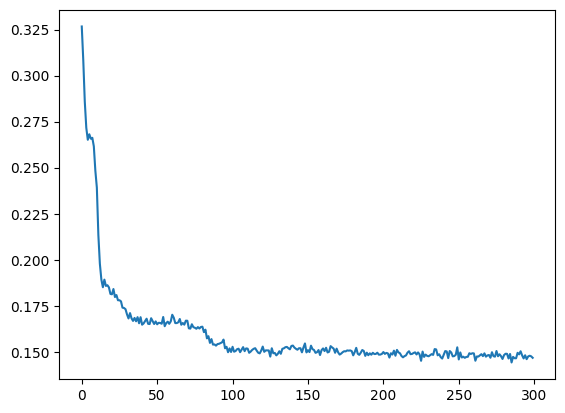

In [15]:
import matplotlib.pyplot as plt
plt.plot(np.arange(len(loss_log['up_end_mae'])), loss_log['up_end_mae'])
plt.show()

In [17]:
torch.save(up_changer.state_dict(), 'submission_files/tim_deep6_reconstr/up_changer300.pth')

In [134]:
# to generate test predictions
testloader = DataLoader(list(zip(lr_X_dim1_test, lr_X_dim3, lr_test)), shuffle=True, batch_size=16)

up_changer.eval()
test_predictions = []
for X_lr, Y_lr, adj_lr in tqdm(testloader):
    pred = up_changer(X_lr.to(DEVICE), Y_lr.to(DEVICE), adj_lr.to(DEVICE))[-1].detach()
    test_predictions.append(pred)
test_predictions = torch.cat(test_predictions)

100%|██████████| 7/7 [00:00<00:00,  9.88it/s]


In [18]:
torch.save(test_predictions, 'submission_files/tim_deep6_reconstr/tim_deep6_reconstr_pred300.pt')

KeyboardInterrupt: 

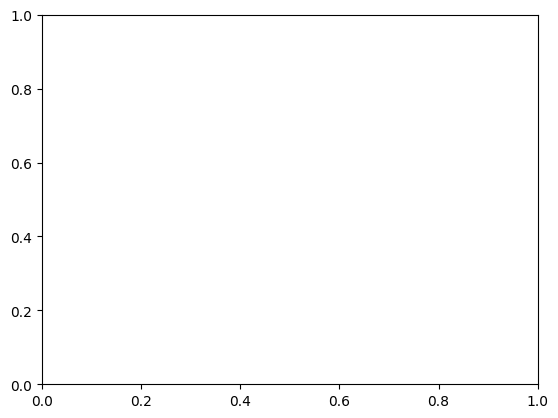

In [135]:
from data_preparation import generate_histogram
generate_histogram(test_predictions.cpu(), hr_train)

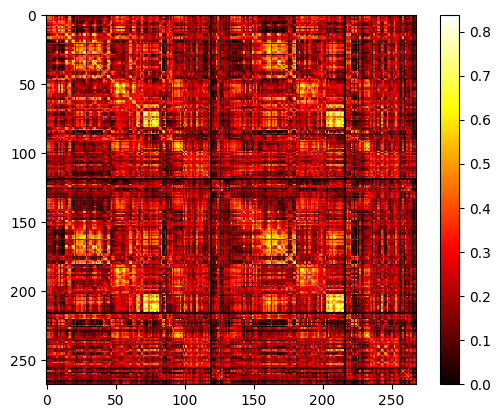

In [26]:
from data_preparation import generate_heatmap
generate_heatmap(test_predictions[0].cpu())

In [19]:
from data_preparation import generate_submission_file

df = generate_submission_file(test_predictions.cpu(), 'submission_files/tim_deep6_reconstr/tim_deep6_reconstr_pred300.csv')

# Cross Validation

In [11]:
from evaluation_fn import evaluate_predictions

def validation(up_changer, testloader, val_adj_hr):
    print('begin validation')
    up_changer.eval()

    val_predictions = []
    for X_lr, Y_lr, adj_lr in tqdm(testloader):
        pred = up_changer(X_lr.to(DEVICE), Y_lr.to(DEVICE), adj_lr.to(DEVICE))[-1].detach()
        val_predictions.append(pred)
    val_predictions = torch.cat(val_predictions)

    return evaluate_predictions(val_predictions, val_adj_hr)

In [12]:
def cross_validate(epochs, batch_size, n_fold, X_lr, Y_lr, adj_lr, X_hr, Y_hr, adj_hr, num_steps, f=32):
    kf = KFold(n_fold, shuffle=True, random_state=99)
    runs_results = []
    for train_idx, val_idx in kf.split(X_lr):
        train_X_lr, val_X_lr = X_lr[train_idx], X_lr[val_idx]
        train_Y_lr, val_Y_lr = Y_lr[train_idx], Y_lr[val_idx]
        train_adj_lr, val_adj_lr = adj_lr[train_idx], adj_lr[val_idx]
        train_X_hr = X_hr[train_idx]
        train_Y_hr = Y_hr[train_idx]
        train_adj_hr, val_adj_hr = adj_hr[train_idx], adj_hr[val_idx]

        trainloader = DataLoader(list(zip(train_X_lr, train_Y_lr, train_adj_lr, train_X_hr, train_Y_hr, train_adj_hr)), shuffle=True, batch_size=batch_size)

        dim_steps = generate_steps(num_steps=10)

        up_changer = AdjacencyDimChanger(dim_steps, f=f).to(DEVICE)
        down_changer = AdjacencyDimChanger(dim_steps[::-1], f=f).to(DEVICE)

        up_optimizer = torch.optim.AdamW(up_changer.parameters(), lr=0.001, betas=(0.5, 0.999))
        down_optimizer = torch.optim.AdamW(down_changer.parameters(), lr=0.001, betas=(0.5, 0.999))    
        
        up_changer, down_changer, _ = train(epochs, up_changer, down_changer, trainloader, up_optimizer, down_optimizer)

        testloader = DataLoader(list(zip(val_X_lr, val_Y_lr, val_adj_lr)), shuffle=True, batch_size=batch_size)
        val_metrics = validation(up_changer, testloader, val_adj_hr)
        runs_results.append(val_metrics)

    return runs_results

In [15]:
cross_validate(5, 32, 3, lr_X_dim1, lr_X_dim3, lr_train, hr_X_dim1, hr_X_dim3, hr_train, num_steps=10)

100%|██████████| 4/4 [00:05<00:00,  1.46s/it]


epoch 0: down loss = 0.16564956307411194, up loss = 0.17200086265802383
Down end adj mae 0.28989551216363907
Up end adj mae 0.30541523545980453


100%|██████████| 4/4 [00:04<00:00,  1.23s/it]


epoch 1: down loss = 0.1615280844271183, up loss = 0.16848218068480492
Down end adj mae 0.2799903079867363
Up end adj mae 0.29920385777950287


100%|██████████| 4/4 [00:04<00:00,  1.22s/it]


epoch 2: down loss = 0.1559770405292511, up loss = 0.16499020531773567
Down end adj mae 0.27102500945329666
Up end adj mae 0.29710303246974945


100%|██████████| 4/4 [00:04<00:00,  1.21s/it]


epoch 3: down loss = 0.15054432675242424, up loss = 0.16159073635935783
Down end adj mae 0.2658237814903259
Up end adj mae 0.28980008512735367


100%|██████████| 4/4 [00:04<00:00,  1.21s/it]


epoch 4: down loss = 0.14580555632710457, up loss = 0.15819920599460602
Down end adj mae 0.24981610849499702
Up end adj mae 0.2819031700491905
begin validation


100%|██████████| 2/2 [00:00<00:00,  4.53it/s]
